In [31]:
%load_ext autoreload
%autoreload 2

import copy
import pandas as pd
import numpy as np
import os
from os.path import join as oj
from tqdm import tqdm
import pickle
import sys

from imodels.importance import R2FExp, GeneralizedMDI, GeneralizedMDIJoint
from imodels.importance import LassoScorer, RidgeScorer, ElasticNetScorer, RobustScorer, LogisticScorer, JointRidgeScorer, JointLogisticScorer, JointRobustScorer, JointLassoScorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_bar, theme, element_text

sys.path.append("../..")
from feature_importance.scripts.simulations_util import *

import random
random.seed(331)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
def get_importance(est, X, y):
    imp_values, scores, n_stumps, n_stumps_chosen, scorer_fits, X_transformed, start_indices = est.get_importance_scores(X, y, diagnostics=True)
    dict_out = {"imp_values": imp_values,
                "scores": scores,
                "n_stumps": n_stumps,
                "n_stumps_chosen": n_stumps_chosen,
                "scorer_fits": scorer_fits,
                "X_transformed": X_transformed,
                "start_indices": start_indices}
    return dict_out

## Linear DGP

In [33]:
n = 500
d = 50
s = 5
beta = 1
heritability = 0.4
N_REPS = 10

In [34]:
linear_results = {rep: {} for rep in range(N_REPS)}
for rep in tqdm(range(N_REPS)):
    X = sample_normal_X(n=n, d=d)
    y = linear_model(X, sigma=None, s=s, beta=beta, heritability=heritability)
    # X = np.concatenate((X[:, 1:], X[:, 0:1]), axis=1)

    rf_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=int(d/3), random_state=rep)

    ridge_scorer = JointRidgeScorer(criterion="gcv", metric="loocv")
    lasso_scorer = JointLassoScorer()

    ridge_gmdi_raw = GeneralizedMDIJoint(
        copy.deepcopy(rf_model), scorer=copy.deepcopy(ridge_scorer),
        normalize_raw=True, oob=False, random_state=331
    )
    linear_results[rep]["ridge_raw"] = get_importance(ridge_gmdi_raw, X, y)
    ridge_gmdi_no_raw = GeneralizedMDIJoint(
        copy.deepcopy(rf_model), scorer=copy.deepcopy(ridge_scorer),
        normalize_raw=True, oob=False, random_state=331, add_raw=False
    )
    linear_results[rep]["ridge_no_raw"] = get_importance(ridge_gmdi_no_raw, X, y)
    lasso_gmdi_raw = GeneralizedMDIJoint(
        copy.deepcopy(rf_model), scorer=copy.deepcopy(lasso_scorer),
        normalize_raw=True, oob=False, random_state=331
    )
    linear_results[rep]["lasso_raw"] = get_importance(lasso_gmdi_raw, X, y)
    lasso_gmdi_no_raw = GeneralizedMDIJoint(
        copy.deepcopy(rf_model), scorer=copy.deepcopy(lasso_scorer),
        normalize_raw=True, oob=False, random_state=331, add_raw=False
    )
    linear_results[rep]["lasso_no_raw"] = get_importance(lasso_gmdi_no_raw, X, y)

100%|██████████| 10/10 [04:55<00:00, 29.56s/it]


In [35]:
linear_results[0]["ridge_raw"]["imp_values"]

array([ 6.60672289e-02,  6.14152177e-02,  6.33514505e-02,  6.18188797e-02,
        6.05734072e-02, -1.66043369e-03, -3.00028841e-04,  4.54956275e-03,
       -1.42234019e-03, -3.37698812e-04,  1.18806667e-03, -2.43963213e-04,
       -8.08289909e-04, -1.16922607e-04,  4.50780673e-03,  7.10067834e-04,
       -5.44681666e-04, -1.33686180e-03,  3.47327487e-05, -8.63735923e-05,
       -5.18073617e-04,  1.51440378e-03,  5.81099030e-03,  4.65864146e-04,
        7.09894081e-04, -1.17148164e-04, -4.92605950e-04,  3.50874904e-03,
        2.23480805e-03,  2.85548513e-04, -3.30610670e-04,  5.13178794e-04,
        1.46349916e-03, -3.61509343e-04, -6.13565951e-04, -6.20331894e-04,
        1.26143388e-03, -7.65205987e-04, -5.43446478e-04, -3.47810904e-04,
        2.72578786e-04,  1.12698381e-04, -2.05175071e-03,  7.07828021e-04,
        6.06187699e-05, -3.10910143e-06,  8.38732936e-05,  1.66007900e-04,
        5.86606793e-05, -9.62428057e-04])

In [36]:
linear_results[0]["lasso_raw"]["imp_values"]

array([0.08152947, 0.07086679, 0.07687836, 0.07508517, 0.07663827,
       0.00285077, 0.00466528, 0.01083143, 0.00405241, 0.00591656,
       0.00808629, 0.00536736, 0.00414705, 0.00606603, 0.01321109,
       0.00789993, 0.0044091 , 0.00330854, 0.00516232, 0.00588384,
       0.0038514 , 0.00778537, 0.01387638, 0.00646518, 0.00575265,
       0.0050631 , 0.00508555, 0.0123213 , 0.00958034, 0.00621067,
       0.00560807, 0.00638386, 0.00781551, 0.00504527, 0.00471076,
       0.00388418, 0.00776418, 0.0038214 , 0.00465804, 0.0053706 ,
       0.00652583, 0.00661512, 0.00335373, 0.00624729, 0.00483726,
       0.00678182, 0.00622048, 0.0064191 , 0.00527309, 0.00324056])

In [37]:
linear_results[0]["ridge_raw"]["scorer_fits"][0].coef_

array([ 1.06236188e+00,  6.05229157e-01,  7.07200705e-01,  4.14432268e-01,
       -3.39326812e-01,  1.20234809e+00,  1.27297539e-01,  6.40165411e-01,
        2.76911747e+00,  1.16290758e+00, -6.29967039e-01,  8.48064729e-01,
        7.21932636e-02,  2.29292784e-01, -5.89362850e-01,  7.22151528e-01,
        1.45737988e-01, -6.29536158e-02,  9.43266487e-01, -3.63420420e-01,
        2.06972711e-01,  8.68216052e-01,  1.03302611e-01,  3.22435948e-02,
        1.04169627e+00,  2.04310482e-03, -5.21698392e-01, -5.46132473e-01,
       -6.33908442e-01, -6.61616818e-01, -4.07781867e-01,  5.97583034e-01,
        6.25447317e-01,  1.72818501e-01,  3.96570241e-01,  4.42256191e-01,
       -1.37722022e+00,  7.35381994e-01,  1.18833643e+00, -1.57660827e-01,
        7.42681515e-01, -4.69328399e-01,  7.65586447e-01,  5.21443963e-01,
        5.00543400e-01, -3.04501996e-01,  4.29918322e-01,  9.88302995e-01,
        3.19716746e-01, -6.45333065e-01,  3.04310905e-01,  4.11501040e-01,
       -1.00455199e+00,  

In [38]:
linear_results[0]["lasso_raw"]["scorer_fits"][0].coef_

array([ 1.05134616,  0.54589179,  0.74120628,  0.34315214, -0.29916814,
        1.29090214,  0.        ,  0.61255298,  3.57524677,  1.06825066,
       -0.49193961,  0.67337704,  0.017506  ,  0.        , -0.49260082,
        0.28242818,  0.        , -0.        ,  0.67877381, -0.        ,
        0.        ,  0.65729662,  0.        ,  0.        ,  0.97508606,
       -0.        , -0.46298007, -0.36787058, -0.51123287, -0.41091538,
       -0.13295796,  0.28461266,  0.34002026,  0.        ,  0.25397629,
        0.07645402, -1.47503883,  0.47408307,  1.15096072, -0.00609739,
        0.67869294, -0.33467523,  0.62832983,  0.3910237 ,  0.26604262,
       -0.09109383,  0.08028657,  0.83902475,  0.20744433, -0.56732942,
        0.16647224,  0.26471994, -0.94142244,  0.        , -0.        ,
        0.2845529 ,  0.        , -1.04105606,  0.63677165,  0.52804877,
        0.00790814, -0.28360178,  0.        ,  0.        , -0.17009454,
       -0.05710418, -0.        ,  0.6055072 , -0.61591014, -0.  

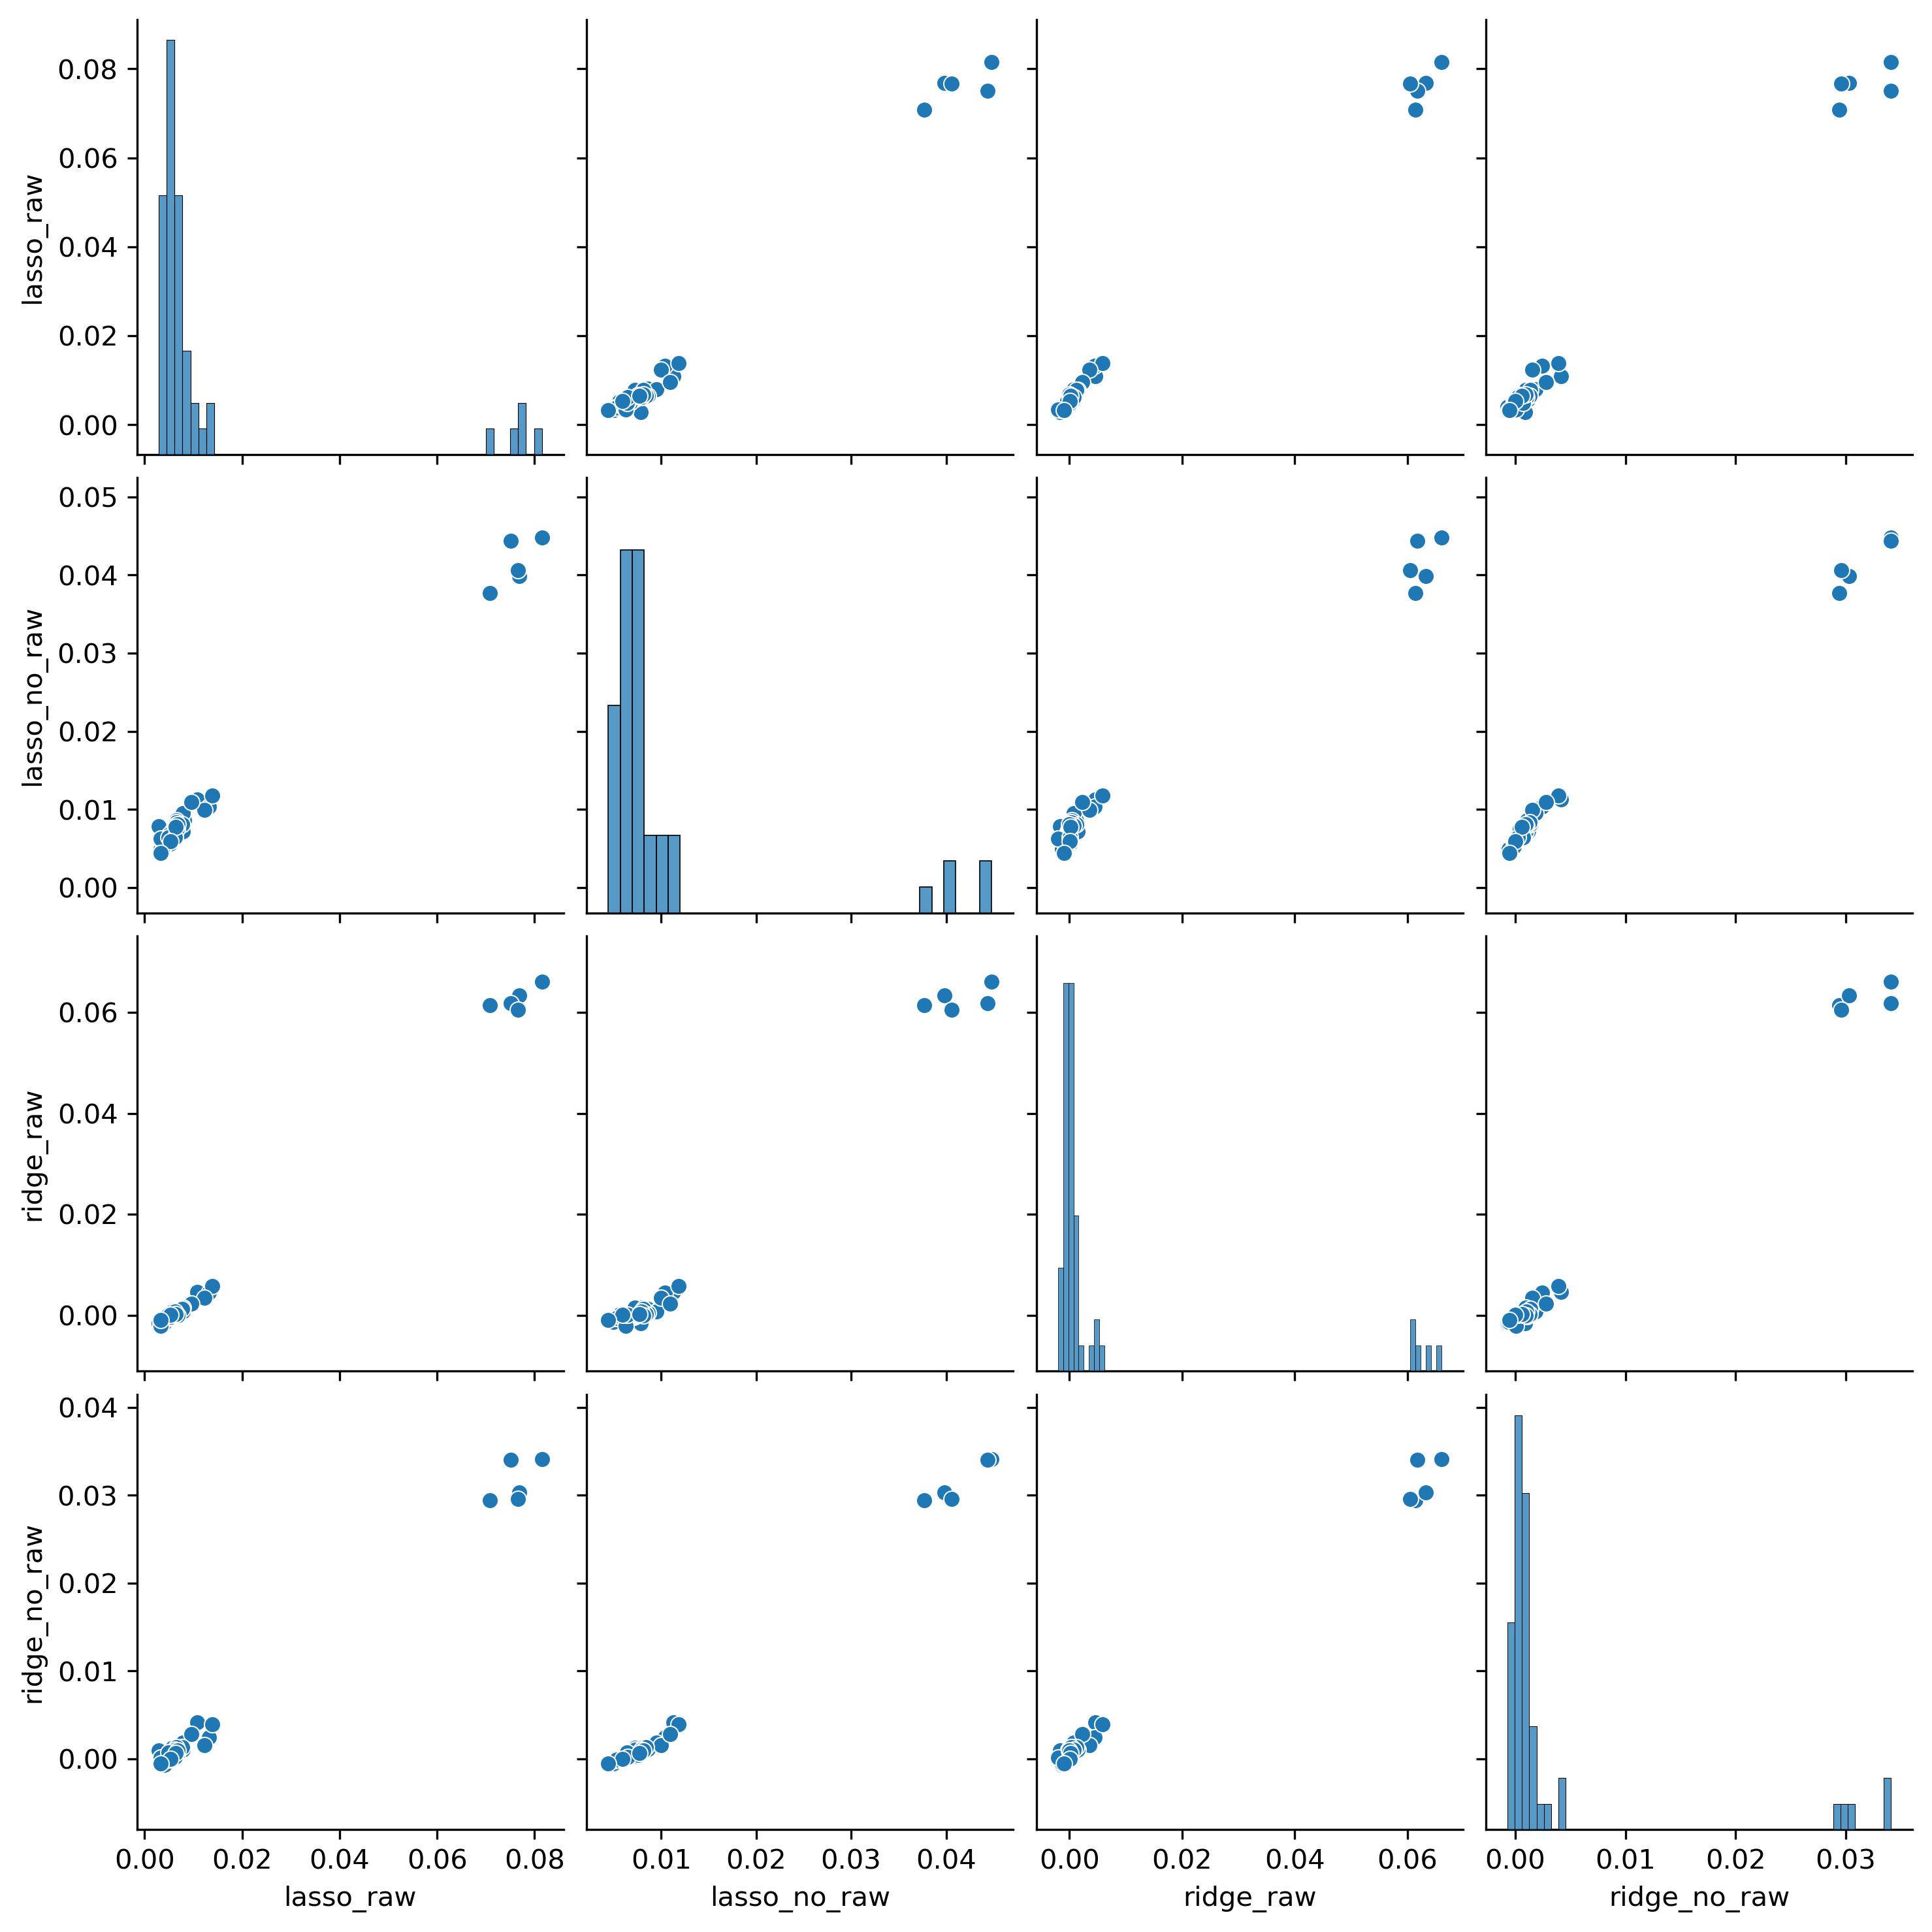

In [39]:
plt_scores_df = pd.DataFrame({
    "lasso_raw": linear_results[0]["lasso_raw"]["imp_values"],
    "lasso_no_raw": linear_results[0]["lasso_no_raw"]["imp_values"],
    "ridge_raw": linear_results[0]["ridge_raw"]["imp_values"],
    "ridge_no_raw": linear_results[0]["ridge_no_raw"]["imp_values"],
})
sns.pairplot(plt_scores_df)

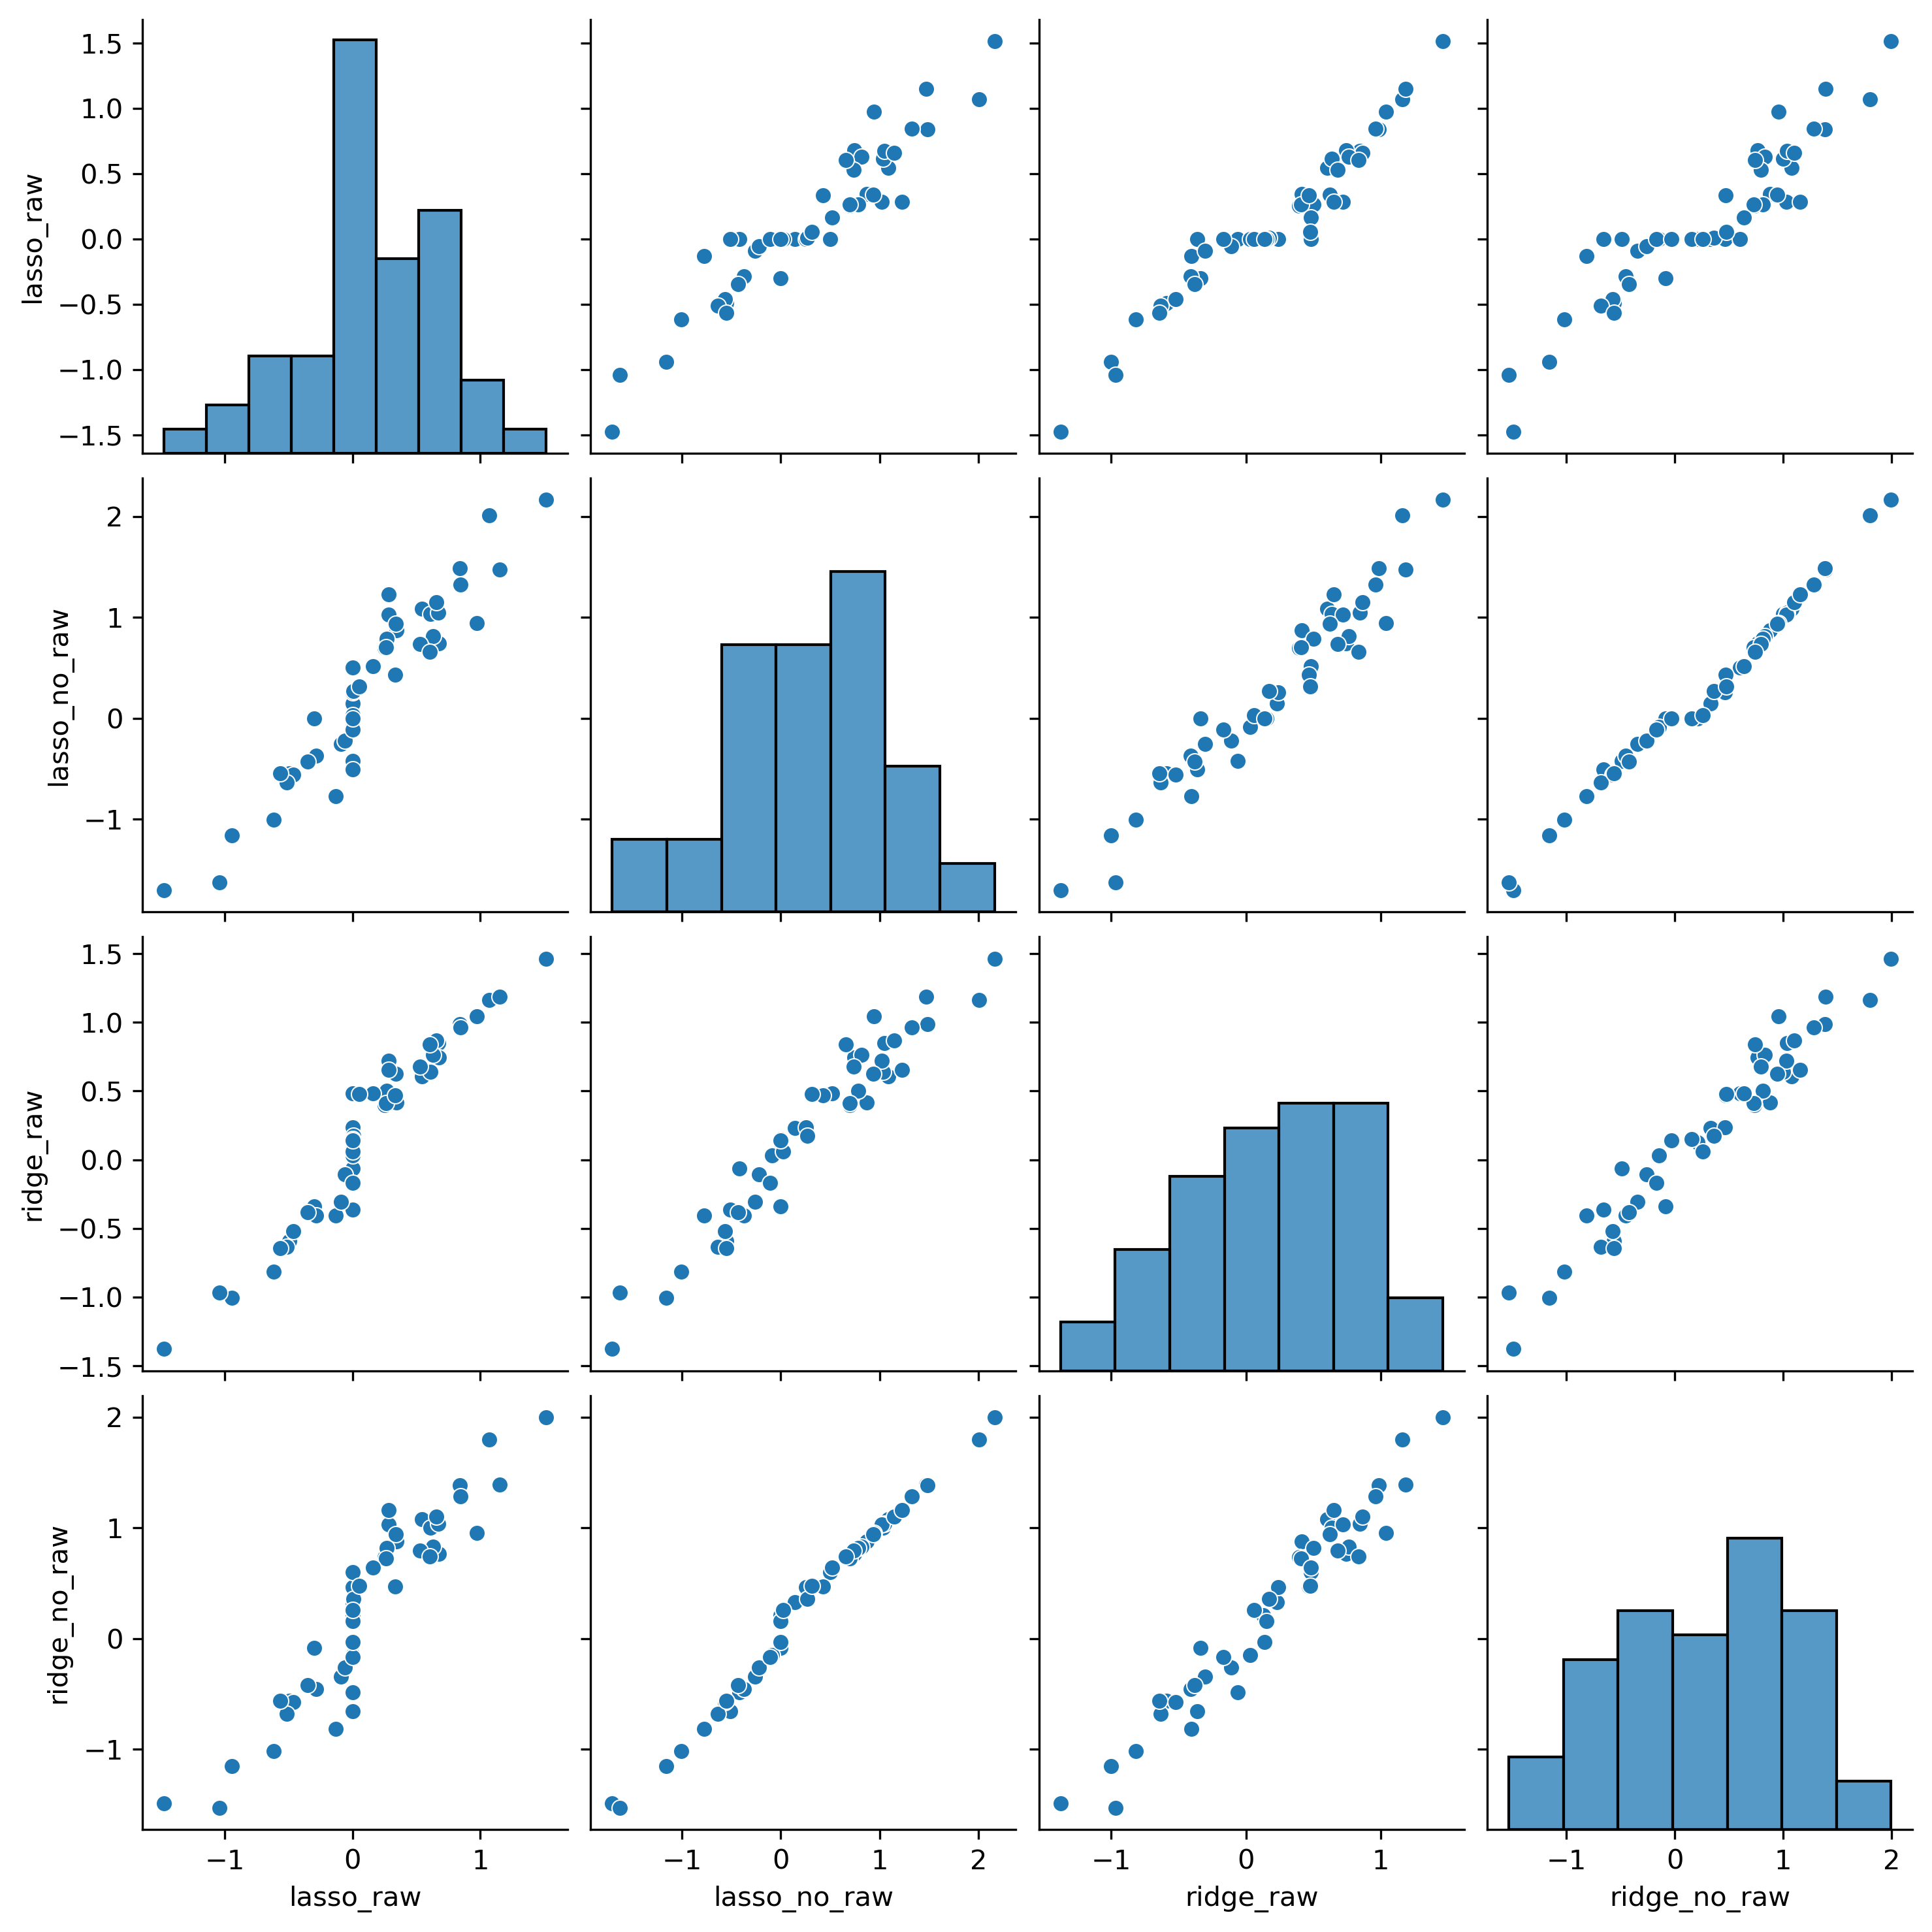

In [40]:
plt_coefs_df = pd.DataFrame({
    "lasso_raw": [coef for i, coef in enumerate(linear_results[0]["lasso_raw"]["scorer_fits"][0].coef_) if i not in linear_results[0]["lasso_raw"]["start_indices"][0][:-1]],
    "lasso_no_raw": linear_results[0]["lasso_no_raw"]["scorer_fits"][0].coef_,
    "ridge_raw": [coef for i, coef in enumerate(linear_results[0]["ridge_raw"]["scorer_fits"][0].coef_) if i not in linear_results[0]["ridge_raw"]["start_indices"][0][:-1]],
    "ridge_no_raw": linear_results[0]["ridge_no_raw"]["scorer_fits"][0].coef_,
})
sns.pairplot(plt_coefs_df)

In [41]:
plt_coefs_df.shape

(50, 4)

In [45]:
len(linear_results[0]["ridge_no_raw"]["scorer_fits"][0].coef_)

50

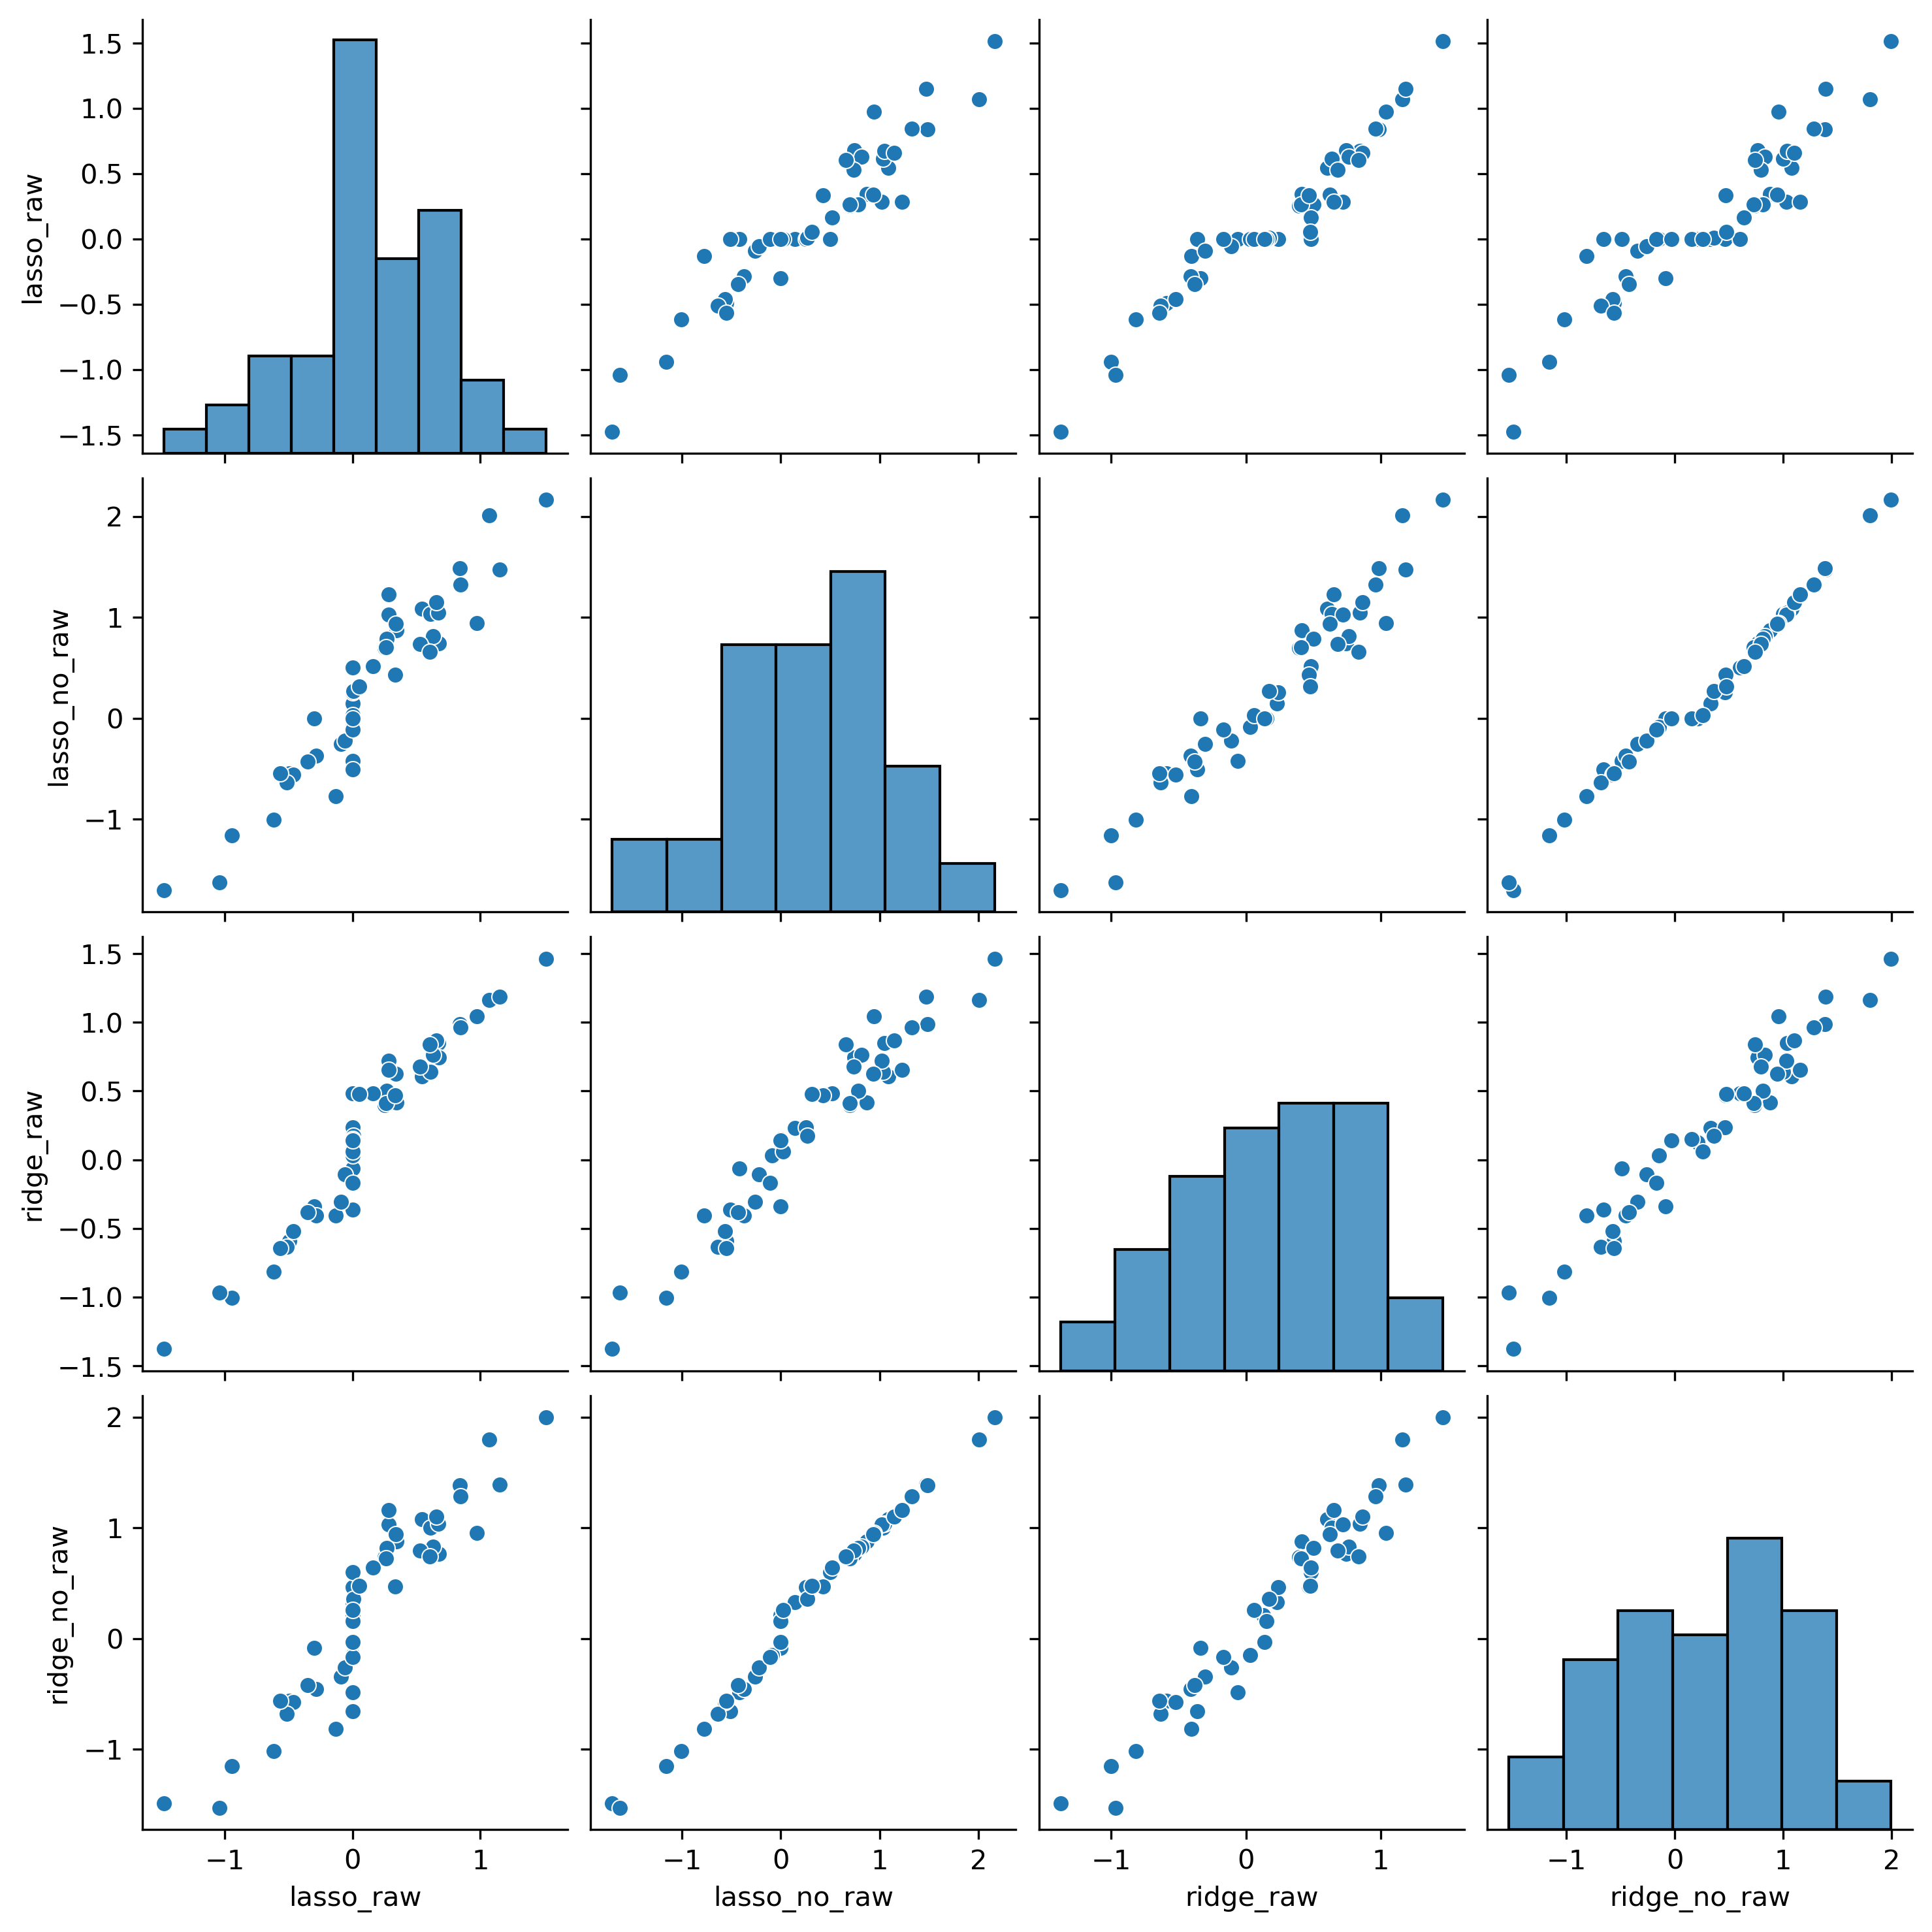

In [46]:
plt_raw_coefs_df = pd.DataFrame({
    "lasso_raw": [coef for i, coef in enumerate(linear_results[0]["lasso_raw"]["scorer_fits"][0].coef_) if i in linear_results[0]["lasso_raw"]["start_indices"][0][:-1]],
    "ridge_raw": [coef for i, coef in enumerate(linear_results[0]["ridge_raw"]["scorer_fits"][0].coef_) if i in linear_results[0]["ridge_raw"]["start_indices"][0][:-1]],
})
sns.pairplot(plt_coefs_df)

In [47]:
plt_raw_coefs_df.shape

(36, 2)

## LSS DGP

In [48]:
n = 500
d = 50
s = 5
beta = 1
heritability = 0.4
N_REPS = 10

In [49]:
lss_results = {rep: {} for rep in range(N_REPS)}
for rep in tqdm(range(N_REPS)):
    X = sample_normal_X(n=n, d=d)
    y = linear_model(X, sigma=None, s=s, beta=beta, heritability=heritability)
    # X = np.concatenate((X[:, 1:], X[:, 0:1]), axis=1)

    rf_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=int(d/3), random_state=rep)

    ridge_scorer = JointRidgeScorer(criterion="gcv", metric="loocv")
    lasso_scorer = JointLassoScorer()

    ridge_gmdi_raw = GeneralizedMDIJoint(
        copy.deepcopy(rf_model), scorer=copy.deepcopy(ridge_scorer),
        normalize_raw=True, oob=False, random_state=331
    )
    lss_results[rep]["ridge_raw"] = get_importance(ridge_gmdi_raw, X, y)
    ridge_gmdi_no_raw = GeneralizedMDIJoint(
        copy.deepcopy(rf_model), scorer=copy.deepcopy(ridge_scorer),
        normalize_raw=True, oob=False, random_state=331, add_raw=False
    )
    lss_results[rep]["ridge_no_raw"] = get_importance(ridge_gmdi_no_raw, X, y)
    lasso_gmdi_raw = GeneralizedMDIJoint(
        copy.deepcopy(rf_model), scorer=copy.deepcopy(lasso_scorer),
        normalize_raw=True, oob=False, random_state=331
    )
    lss_results[rep]["lasso_raw"] = get_importance(lasso_gmdi_raw, X, y)
    lasso_gmdi_no_raw = GeneralizedMDIJoint(
        copy.deepcopy(rf_model), scorer=copy.deepcopy(lasso_scorer),
        normalize_raw=True, oob=False, random_state=331, add_raw=False
    )
    lss_results[rep]["lasso_no_raw"] = get_importance(lasso_gmdi_no_raw, X, y)

100%|██████████| 10/10 [05:16<00:00, 31.69s/it]


In [53]:
lss_results[0]["ridge_no_raw"]["start_indices"][0]

[0,
 0,
 1,
 4,
 9,
 12,
 13,
 13,
 15,
 15,
 17,
 17,
 18,
 20,
 20,
 20,
 21,
 23,
 25,
 25,
 25,
 26,
 26,
 26,
 28,
 28,
 29,
 29,
 32,
 32,
 34,
 34,
 36,
 38,
 39,
 40,
 40,
 41,
 41,
 41,
 41,
 41,
 41,
 42,
 42,
 45,
 46,
 46,
 46,
 46,
 47]

In [56]:
lss_results[0]["ridge_raw"]["start_indices"][0]

[0,
 0,
 2,
 6,
 12,
 16,
 18,
 18,
 21,
 21,
 24,
 24,
 26,
 29,
 29,
 29,
 31,
 34,
 37,
 37,
 37,
 39,
 39,
 39,
 42,
 42,
 44,
 44,
 48,
 48,
 51,
 51,
 54,
 57,
 59,
 61,
 61,
 63,
 63,
 63,
 63,
 63,
 63,
 65,
 65,
 69,
 71,
 71,
 71,
 71,
 73]

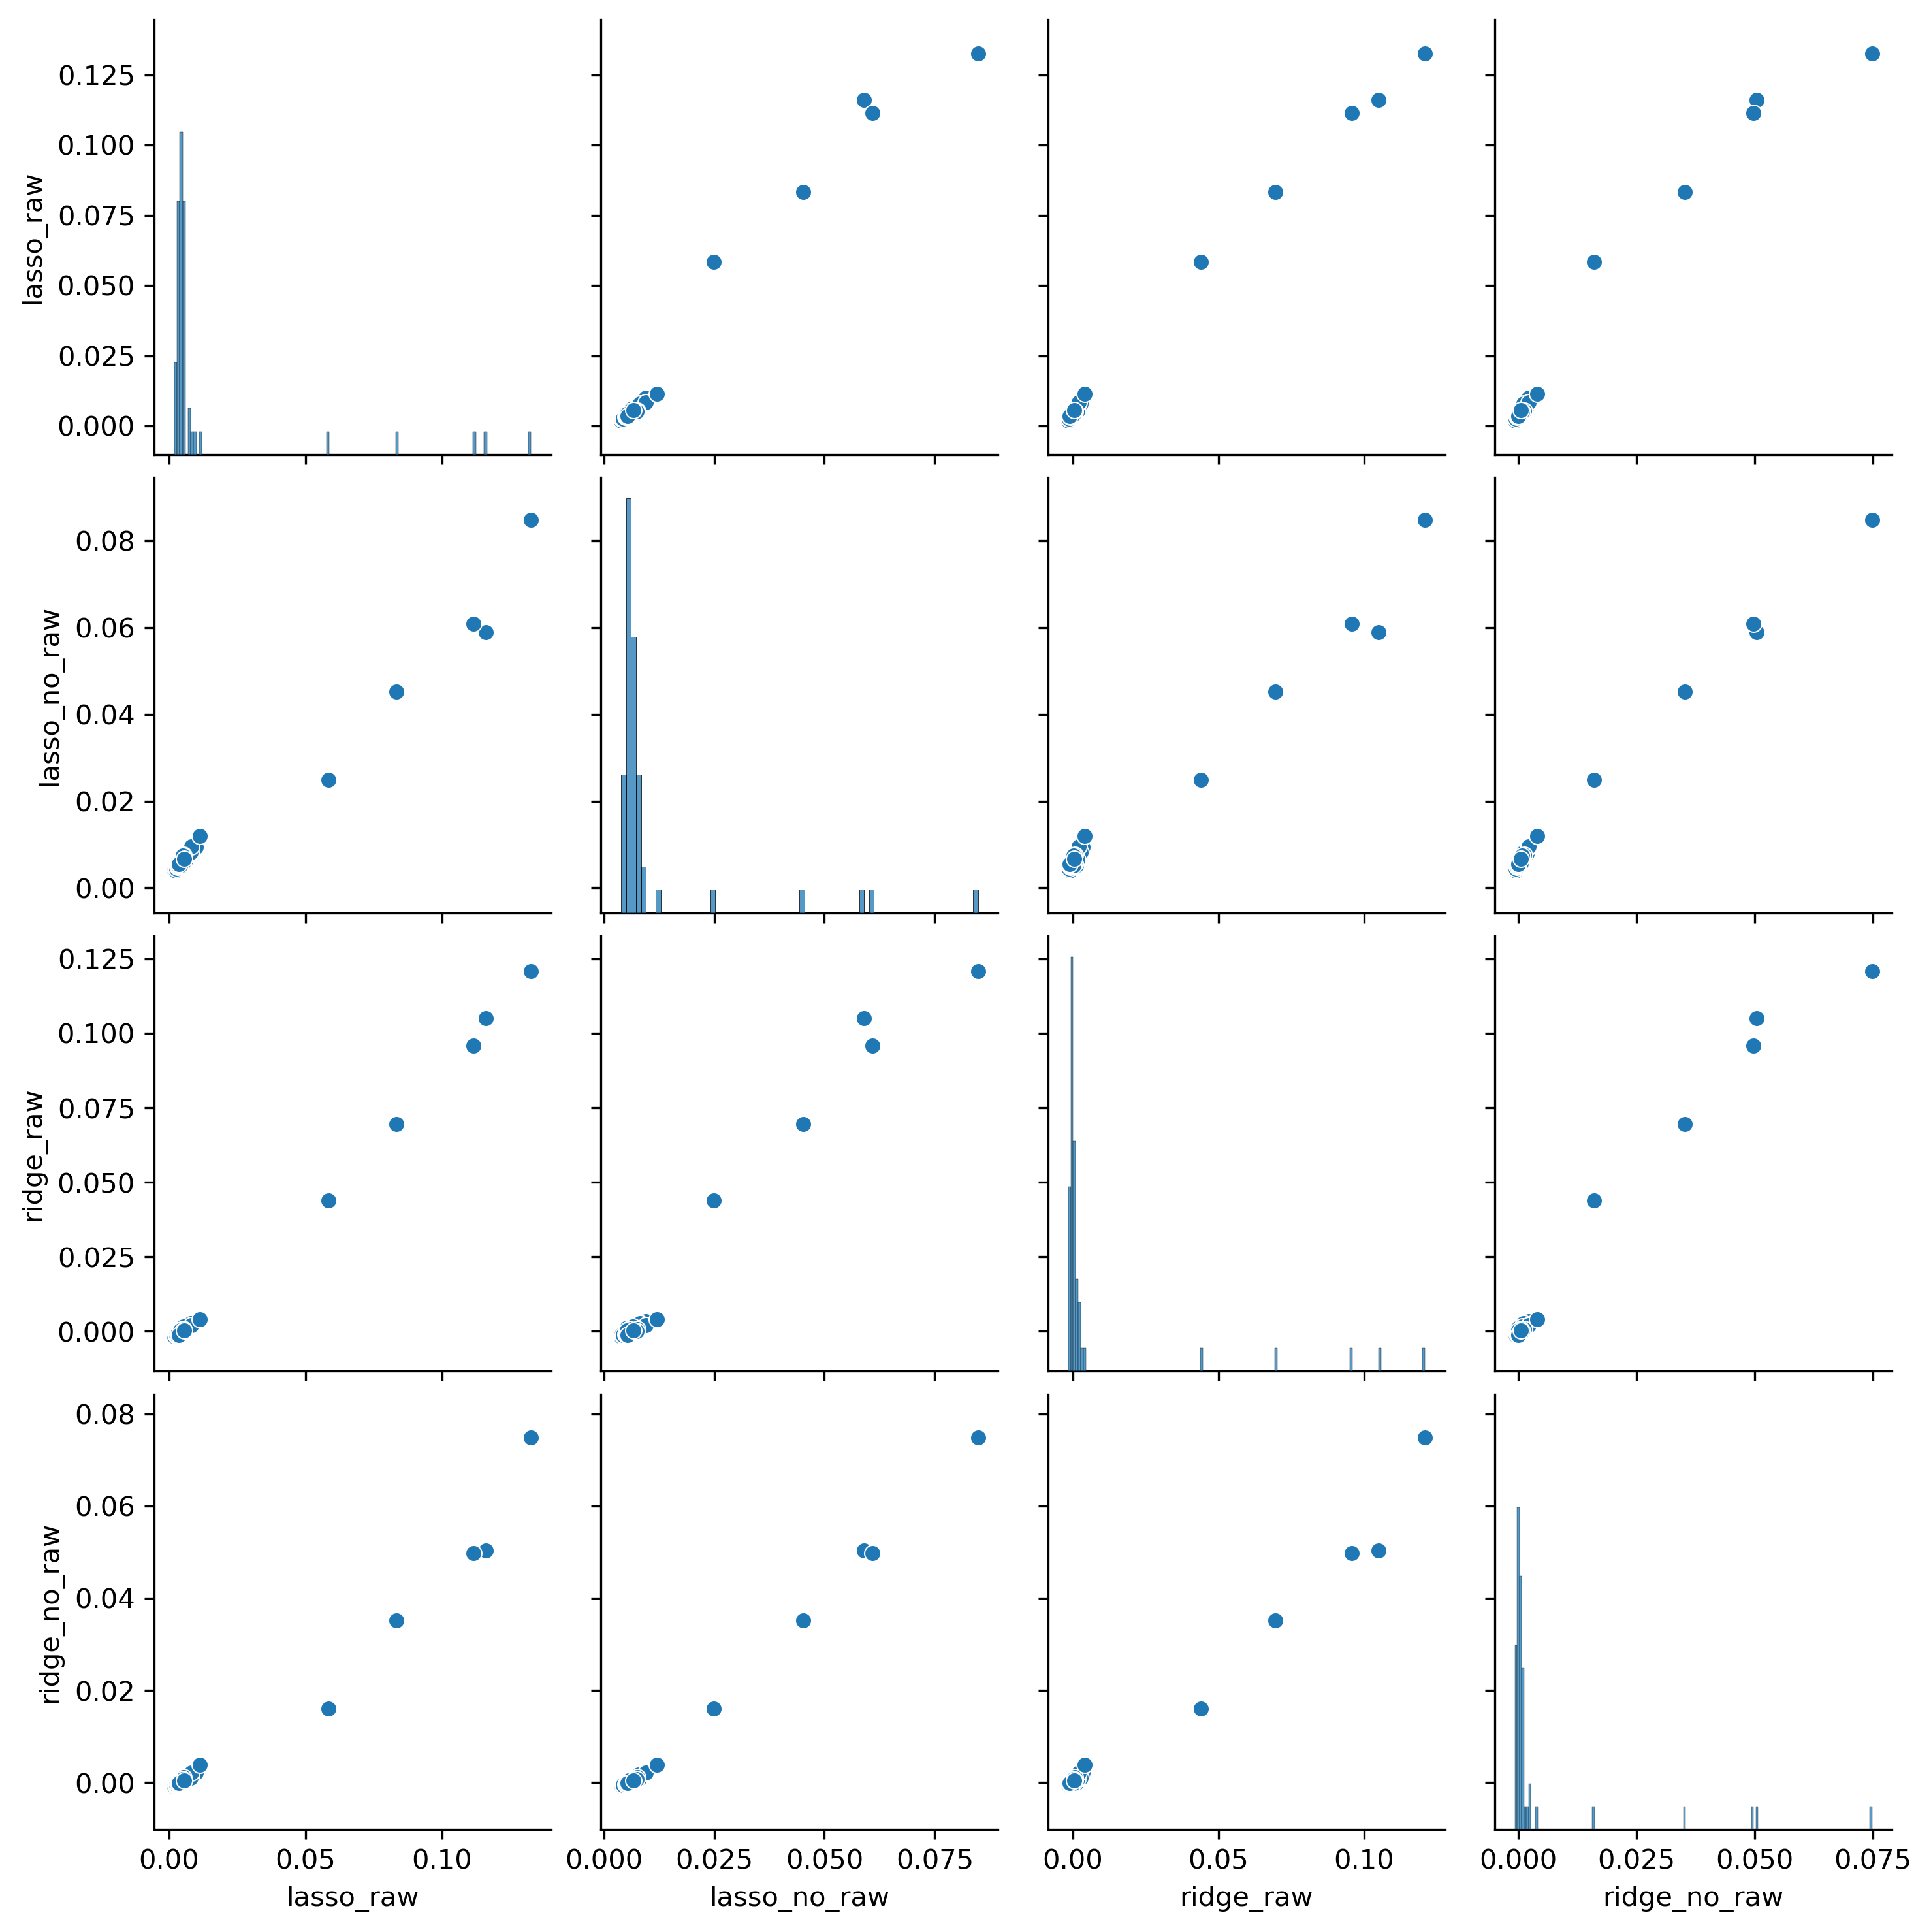

In [57]:
plt_scores_df = pd.DataFrame({
    "lasso_raw": lss_results[0]["lasso_raw"]["imp_values"],
    "lasso_no_raw": lss_results[0]["lasso_no_raw"]["imp_values"],
    "ridge_raw": lss_results[0]["ridge_raw"]["imp_values"],
    "ridge_no_raw": lss_results[0]["ridge_no_raw"]["imp_values"],
})
sns.pairplot(plt_scores_df)

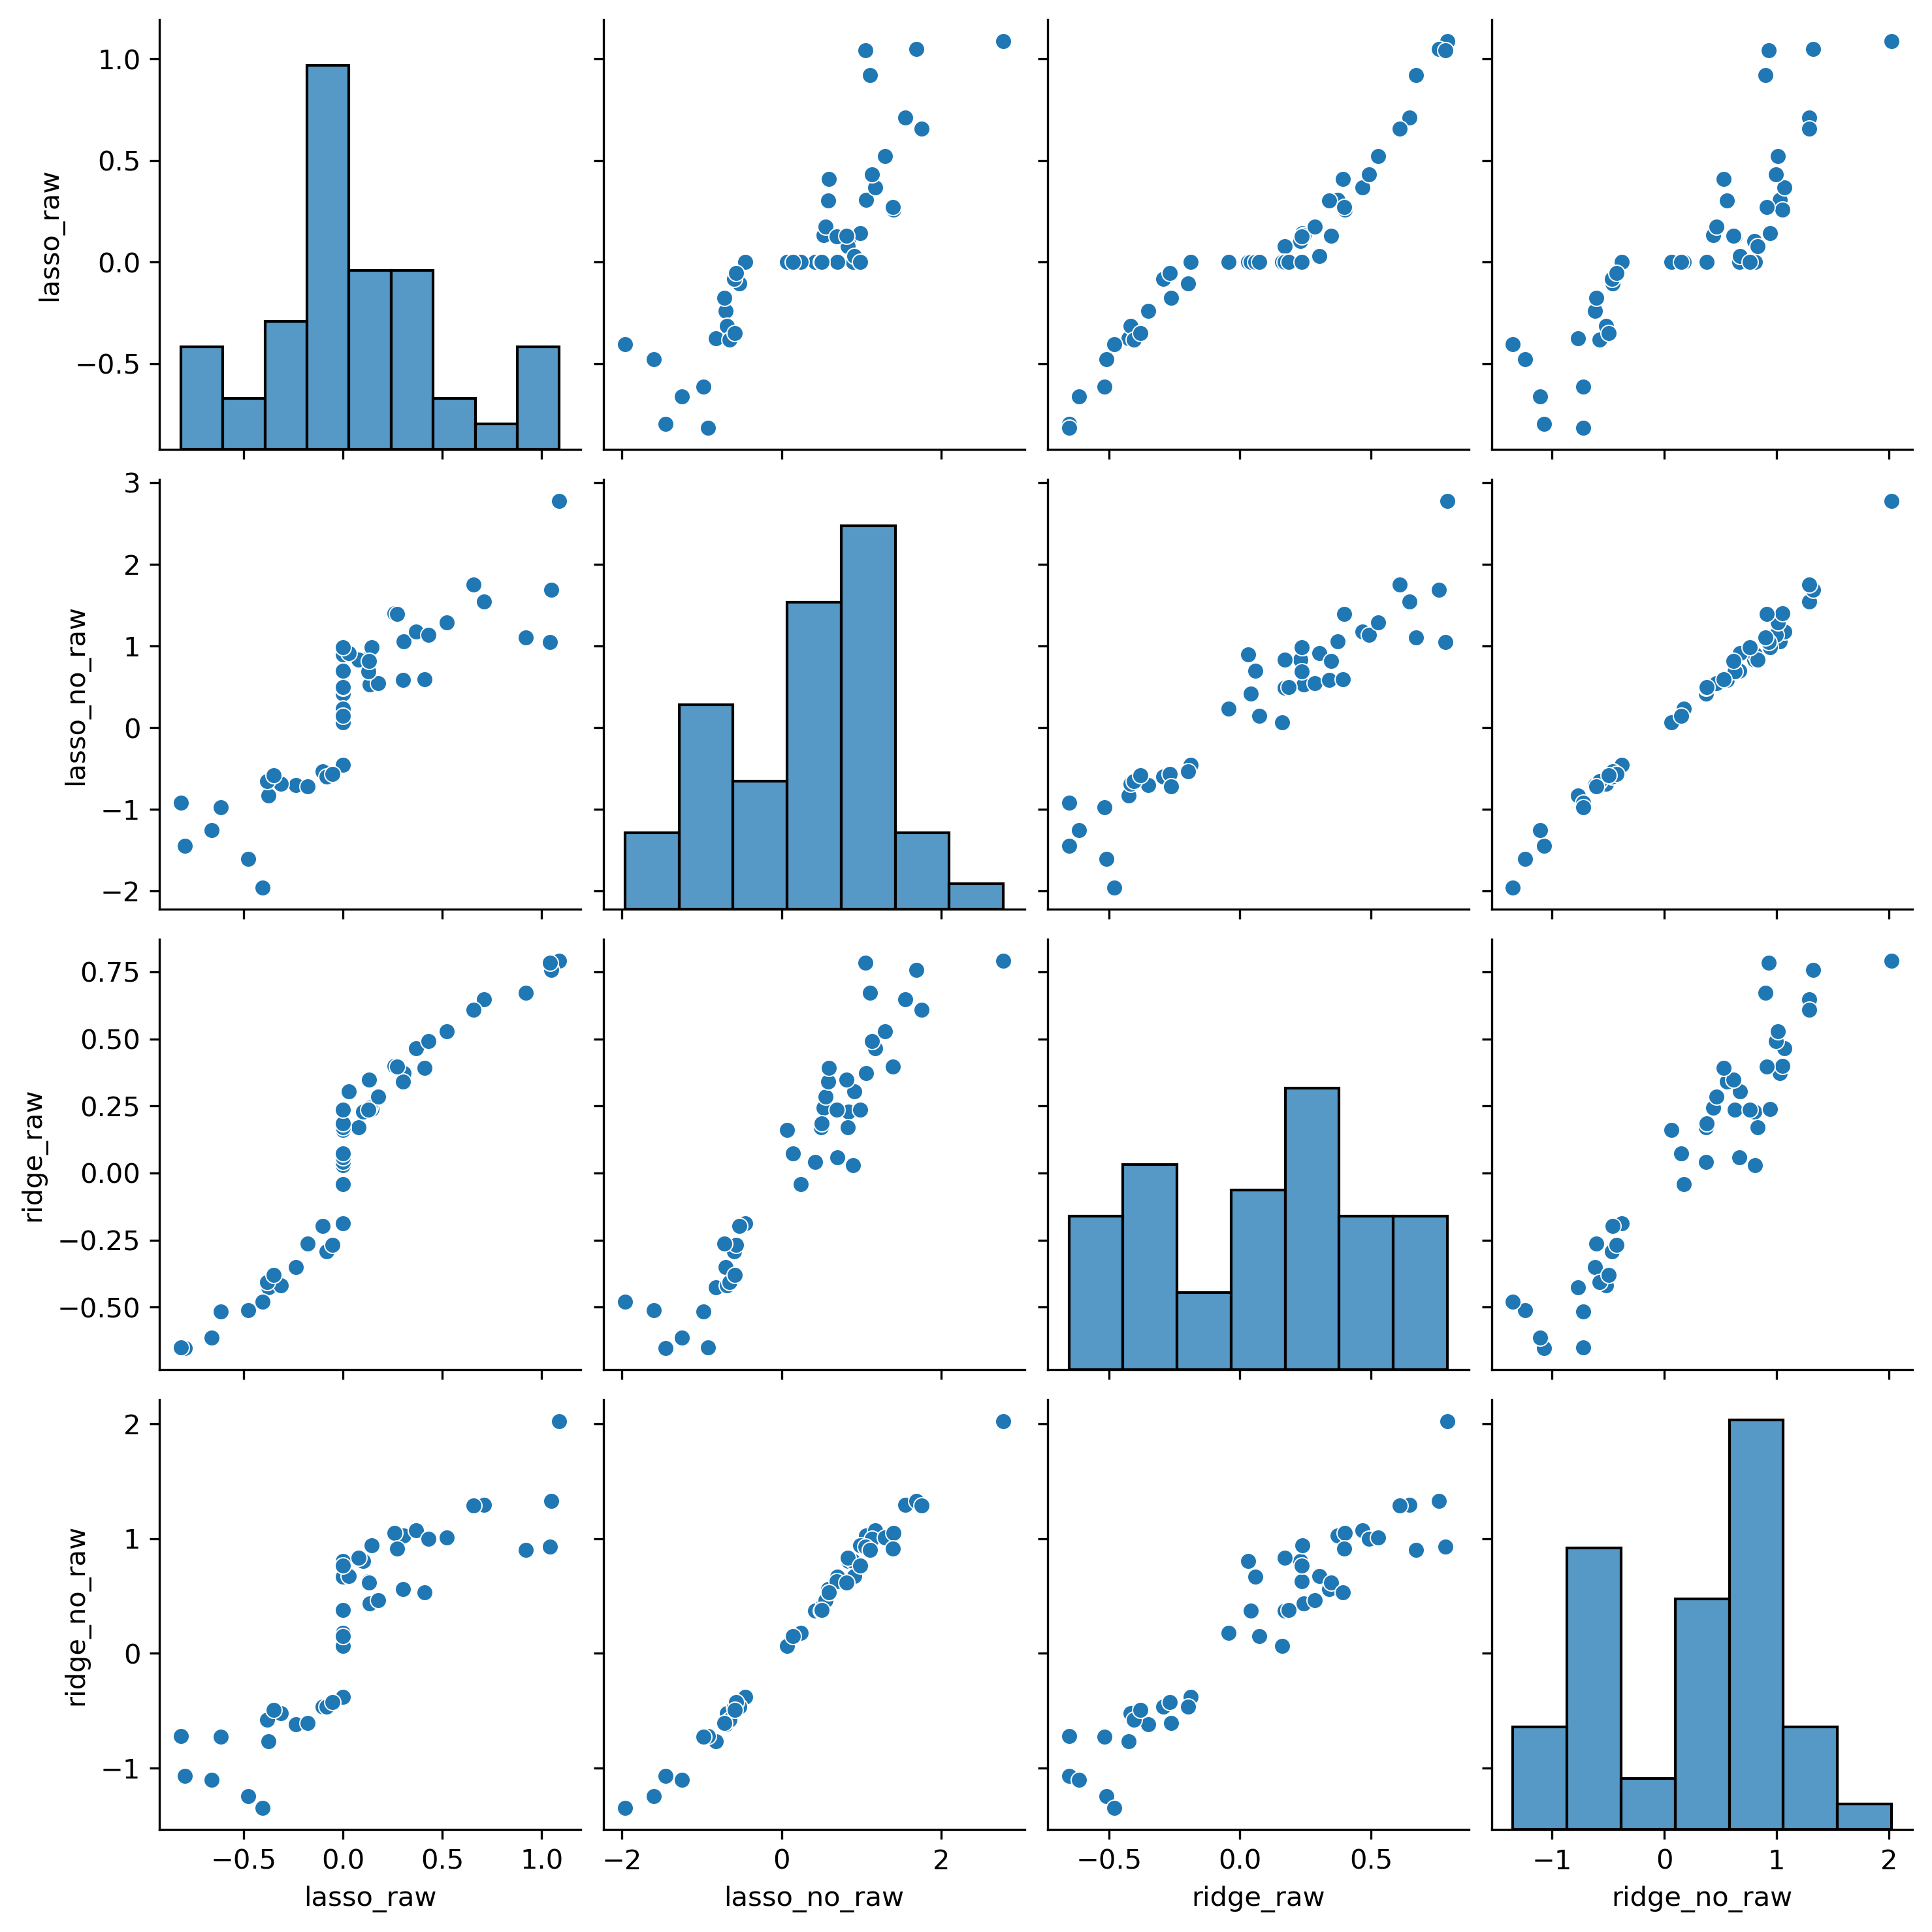

In [58]:
plt_coefs_df = pd.DataFrame({
    "lasso_raw": [coef for i, coef in enumerate(lss_results[0]["lasso_raw"]["scorer_fits"][0].coef_) if i not in lss_results[0]["lasso_raw"]["start_indices"][0][:-1]],
    "lasso_no_raw": lss_results[0]["lasso_no_raw"]["scorer_fits"][0].coef_,
    "ridge_raw": [coef for i, coef in enumerate(lss_results[0]["ridge_raw"]["scorer_fits"][0].coef_) if i not in lss_results[0]["ridge_raw"]["start_indices"][0][:-1]],
    "ridge_no_raw": lss_results[0]["ridge_no_raw"]["scorer_fits"][0].coef_,
})
sns.pairplot(plt_coefs_df)

In [63]:
plt_coefs_df.shape

(47, 4)

In [60]:
len(lss_results[0]["ridge_no_raw"]["scorer_fits"][0].coef_)

47

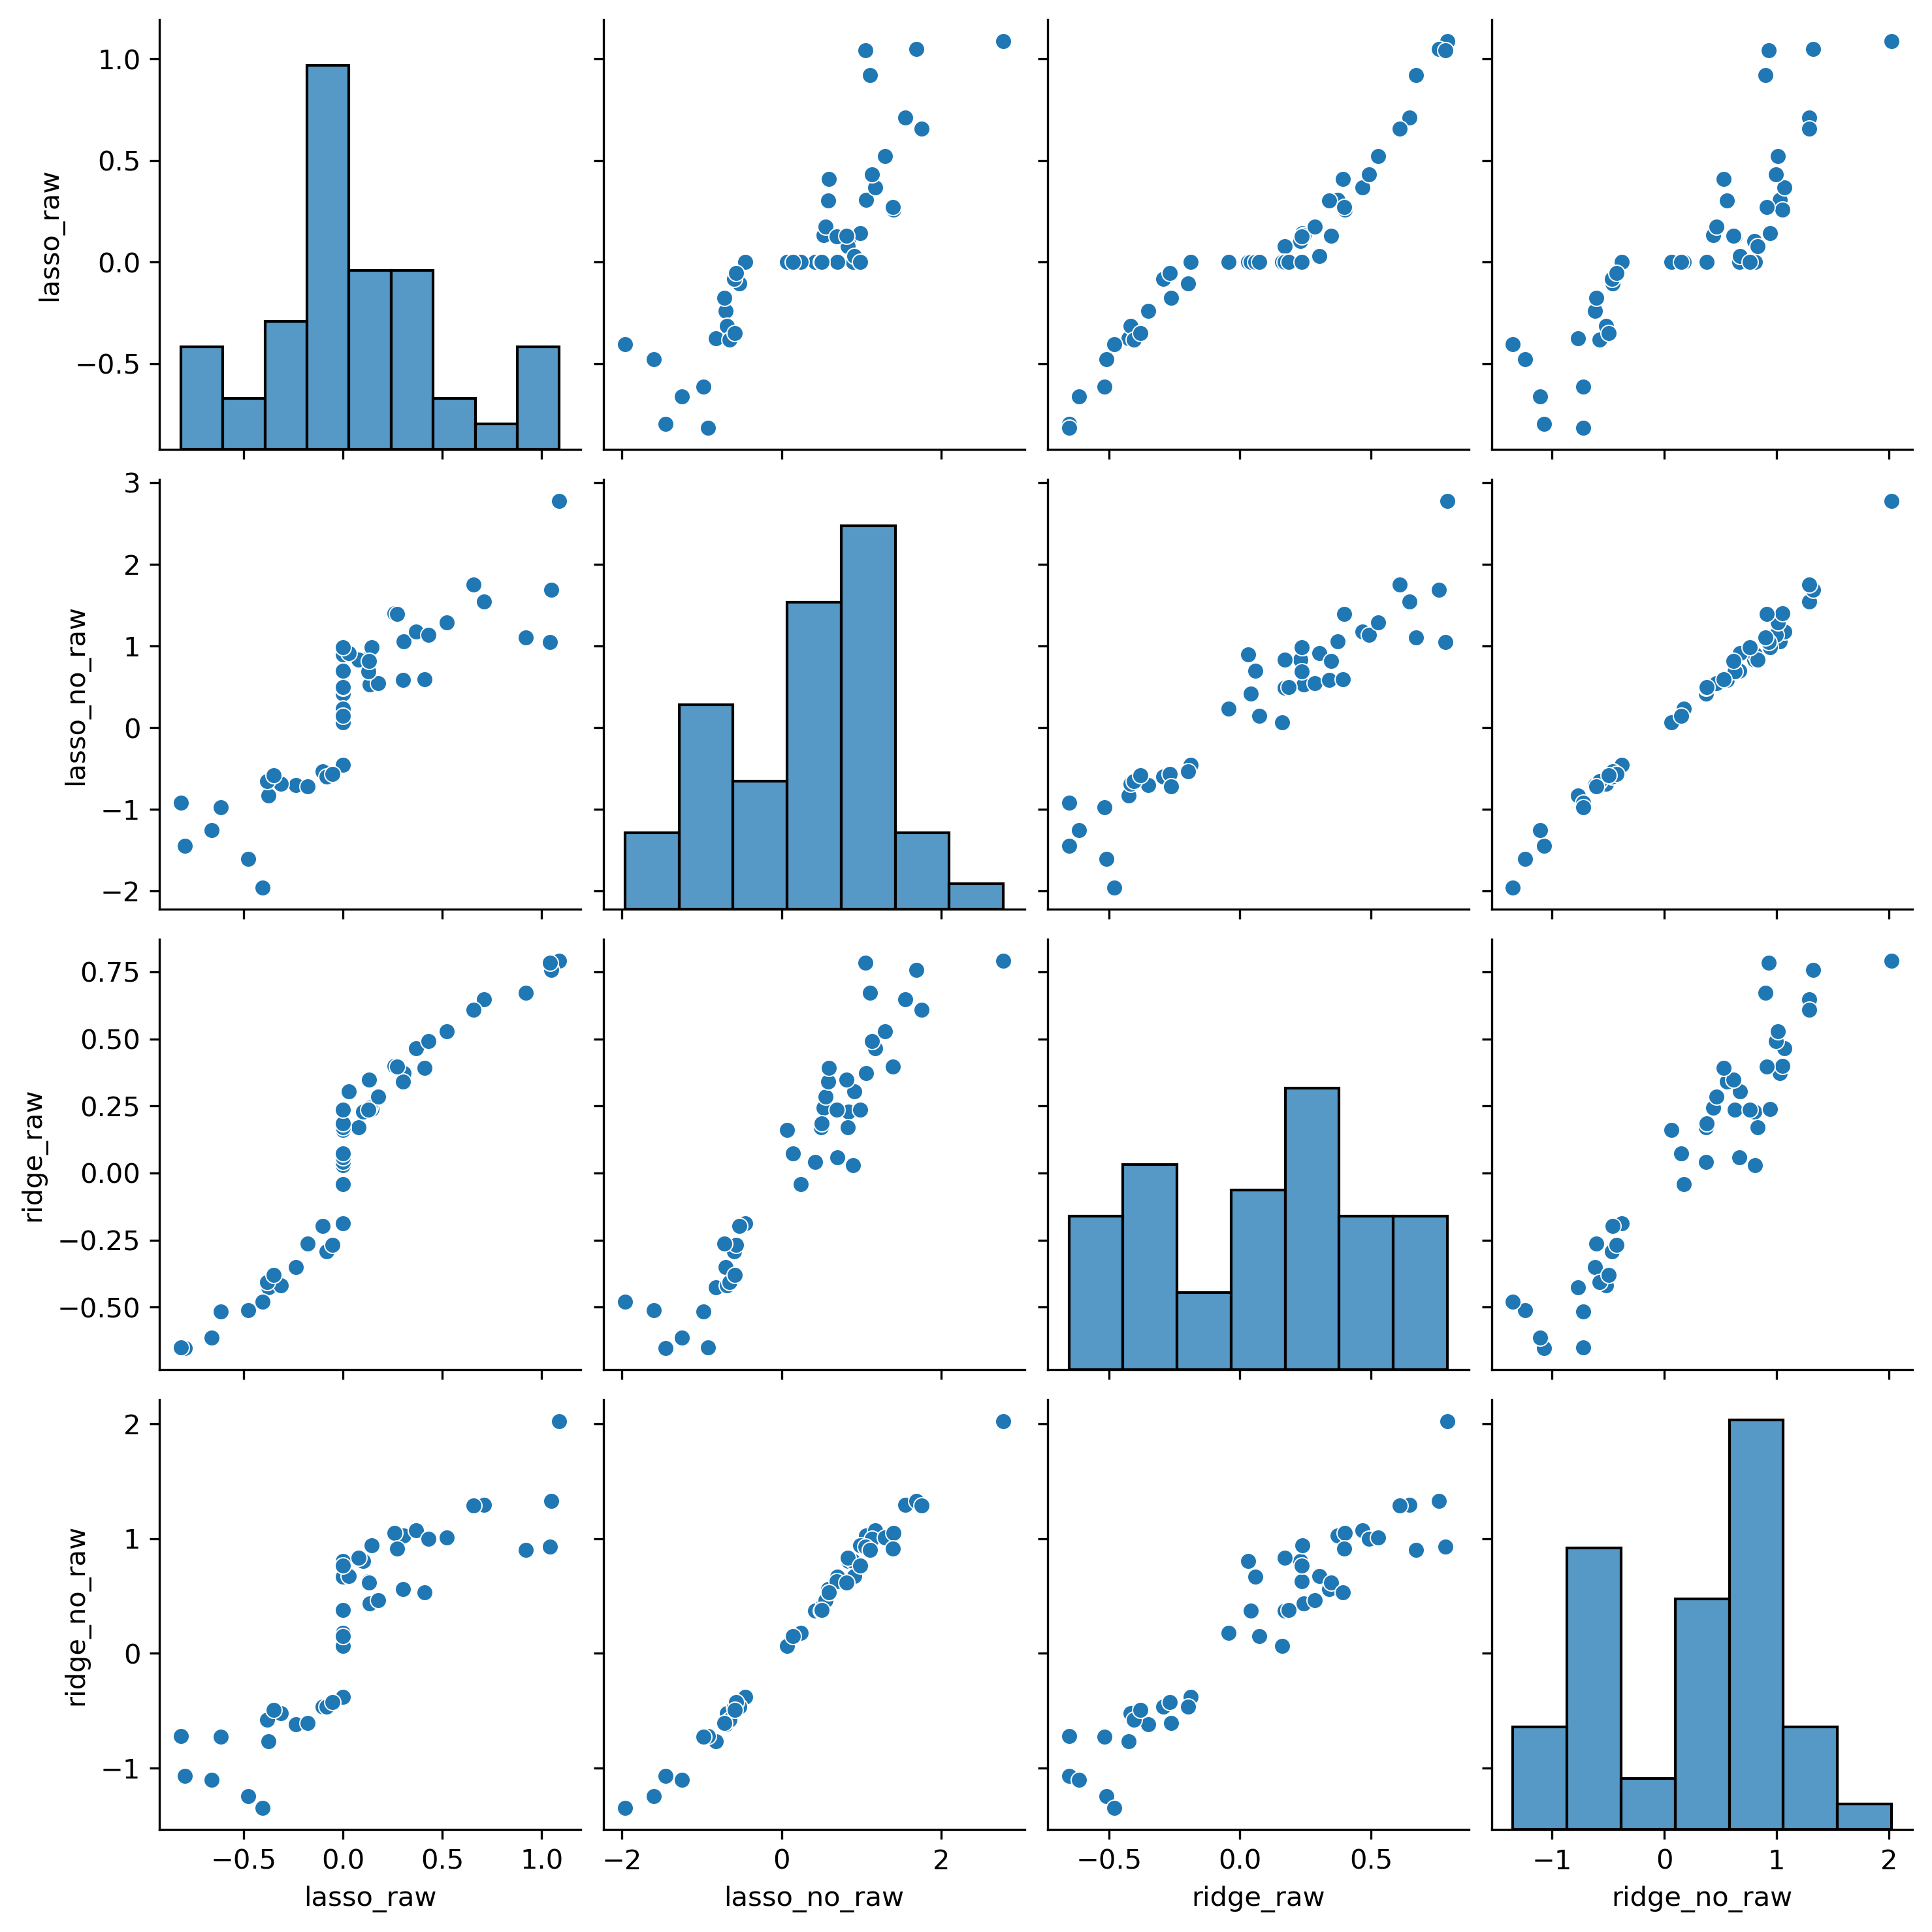

In [61]:
plt_raw_coefs_df = pd.DataFrame({
    "lasso_raw": [coef for i, coef in enumerate(lss_results[0]["lasso_raw"]["scorer_fits"][0].coef_) if i in lss_results[0]["lasso_raw"]["start_indices"][0][:-1]],
    "ridge_raw": [coef for i, coef in enumerate(lss_results[0]["ridge_raw"]["scorer_fits"][0].coef_) if i in lss_results[0]["ridge_raw"]["start_indices"][0][:-1]],
})
sns.pairplot(plt_coefs_df)

In [62]:
plt_raw_coefs_df.shape

(26, 2)

In [69]:
np.mean(np.array([np.mean(fit.coef_ == 0) for fit in lss_results[0]["lasso_raw"]["scorer_fits"].values()]))

0.3434187903471708

In [70]:
np.mean(np.array([np.mean(fit.coef_ == 0) for fit in linear_results[0]["lasso_raw"]["scorer_fits"].values()]))

0.2783754890309614

In [72]:
linear_results[0]["lasso_raw"]["X_transformed"][0].shape

(500, 86)

In [73]:
linear_results[0]["lasso_raw"]["scorer_fits"][0].coef_.shape

(86,)

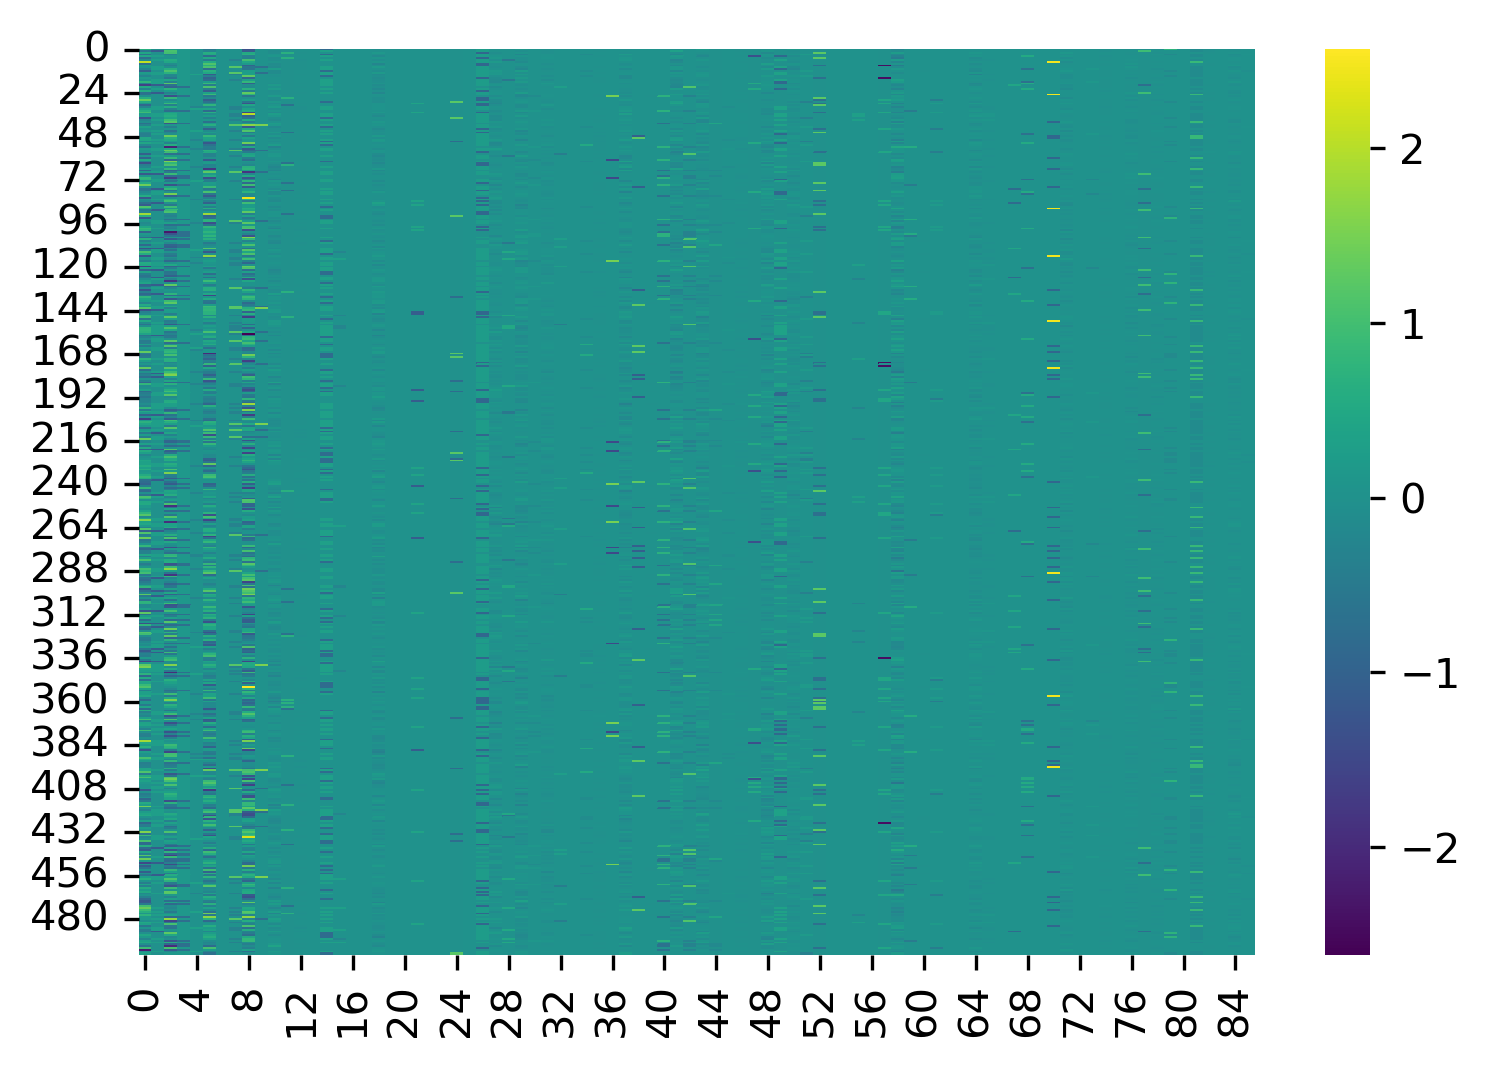

In [79]:
sns.heatmap(linear_results[0]["lasso_raw"]["X_transformed"][0] * linear_results[0]["lasso_raw"]["scorer_fits"][0].coef_, cmap="viridis")

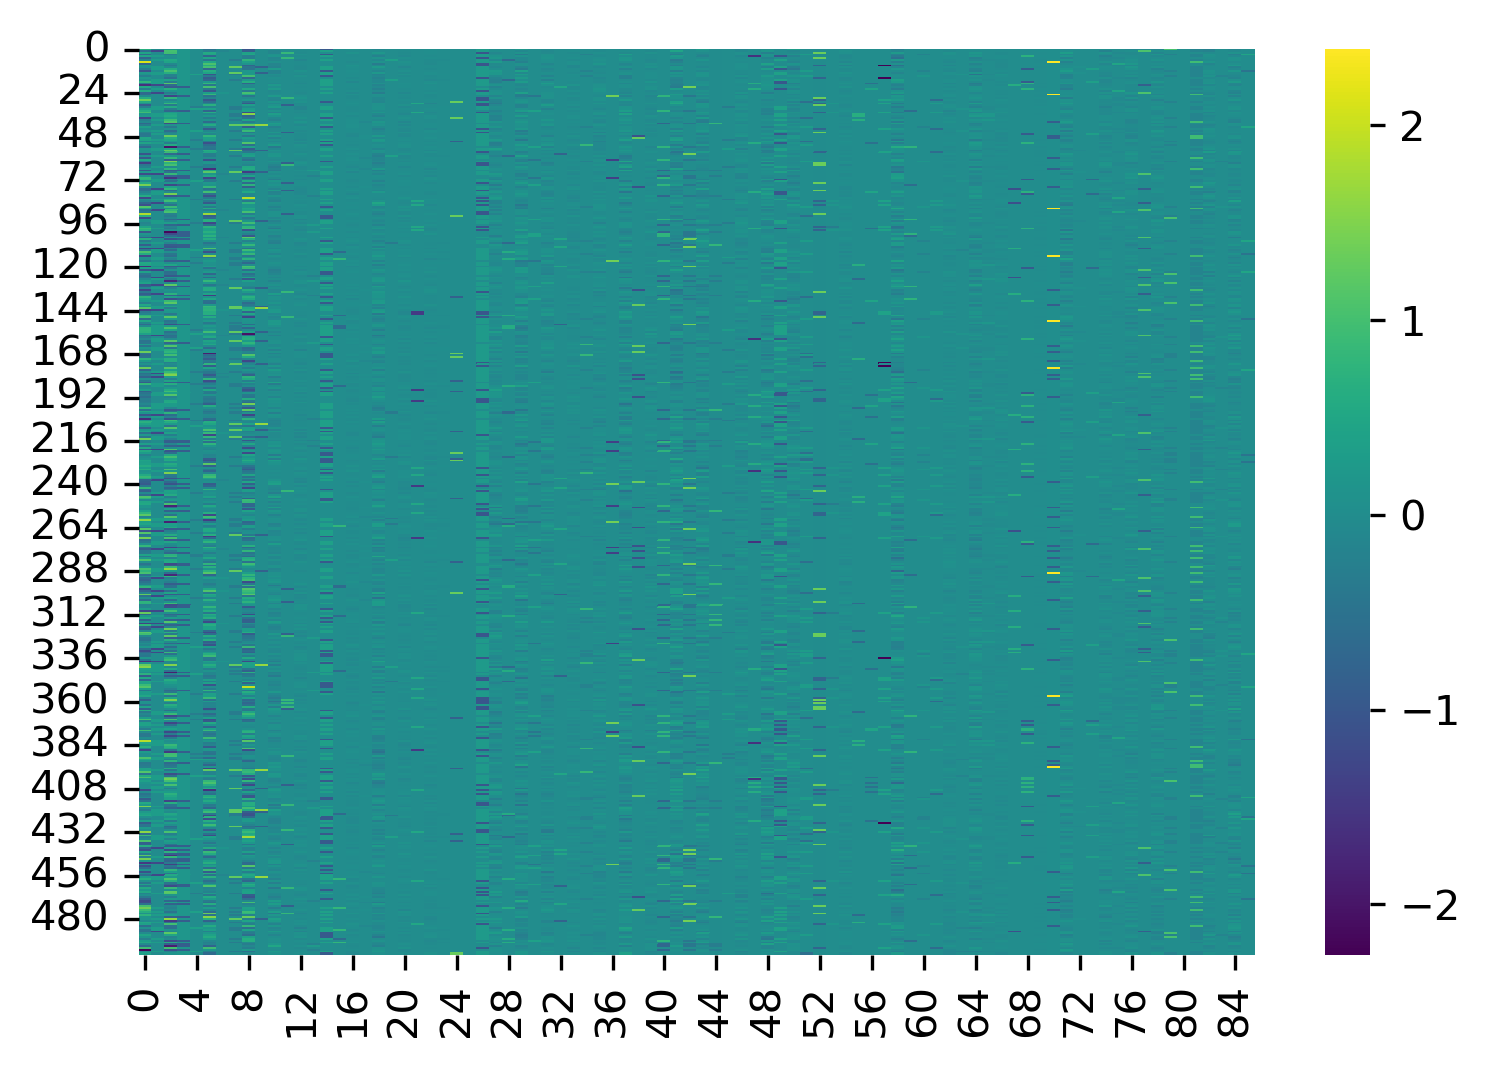

In [80]:
sns.heatmap(linear_results[0]["ridge_raw"]["X_transformed"][0] * linear_results[0]["ridge_raw"]["scorer_fits"][0].coef_, cmap="viridis")

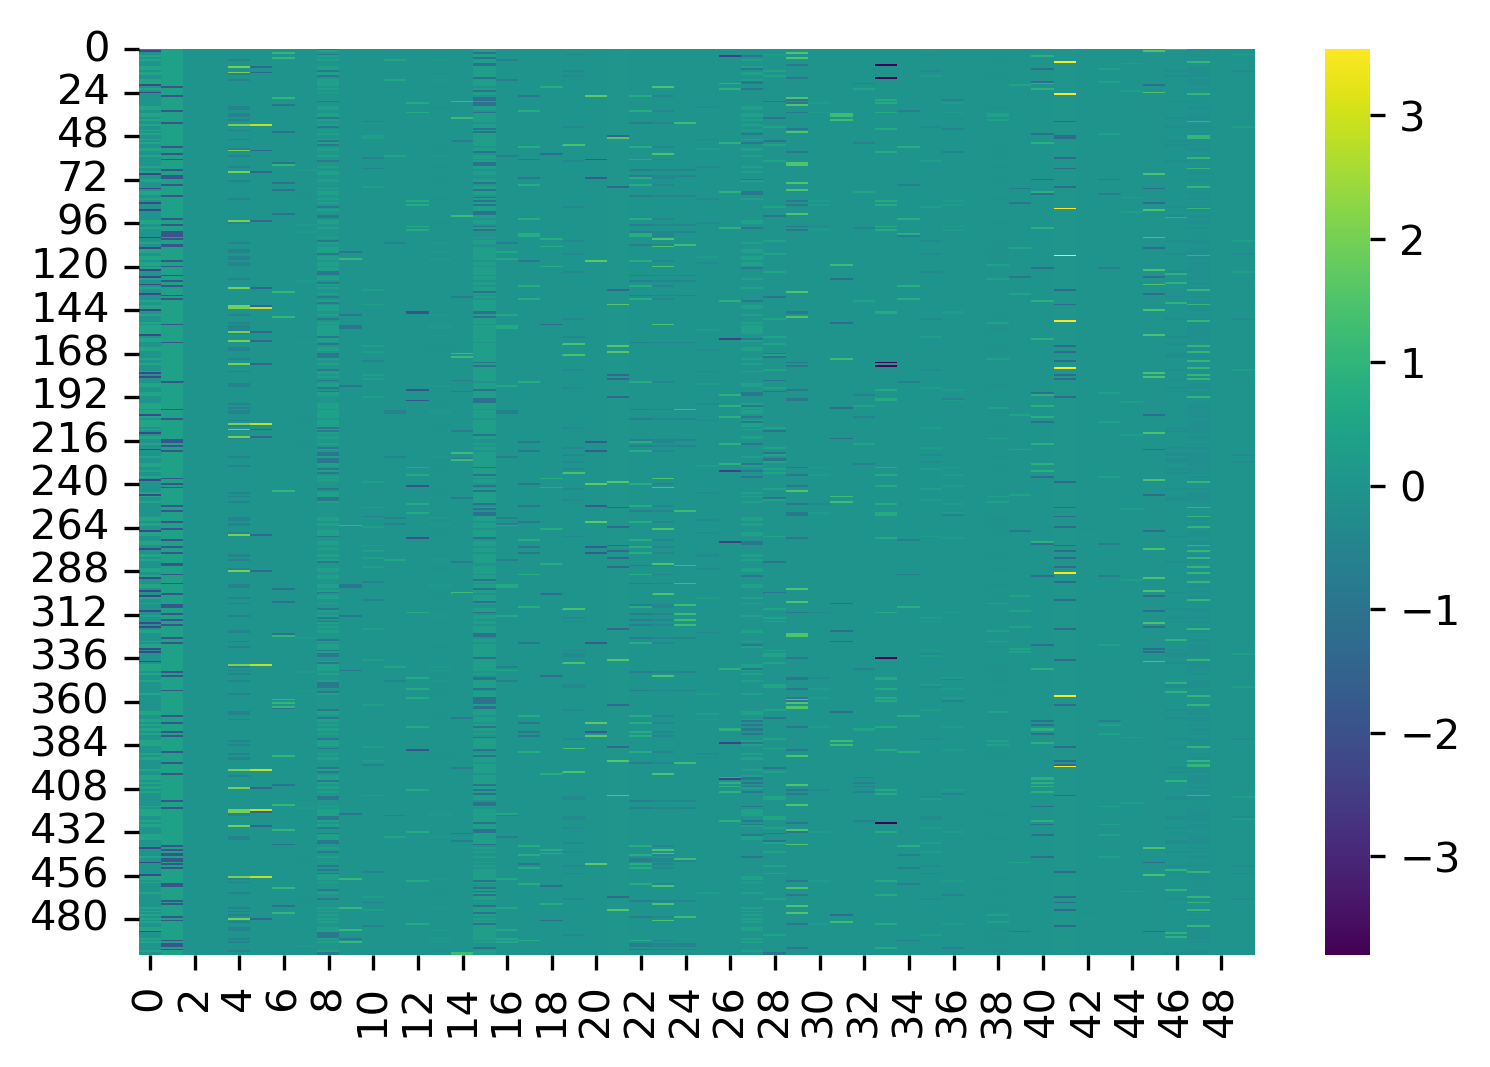

In [81]:
sns.heatmap(linear_results[0]["lasso_no_raw"]["X_transformed"][0] * linear_results[0]["lasso_no_raw"]["scorer_fits"][0].coef_, cmap="viridis")

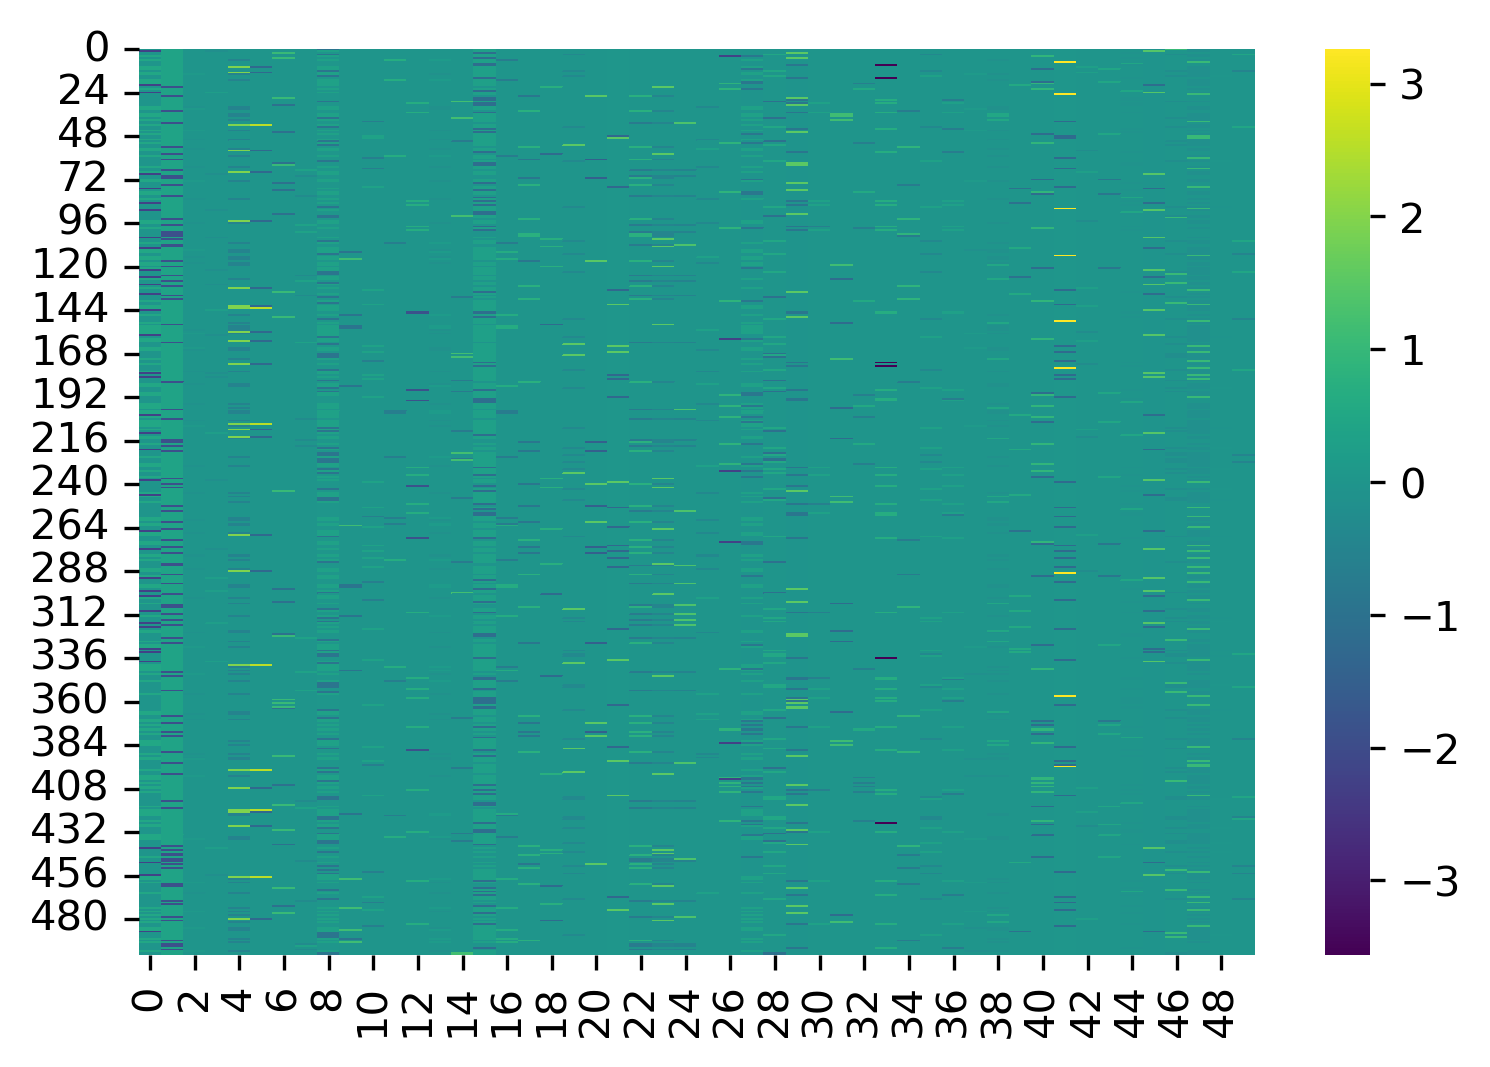

In [82]:
sns.heatmap(linear_results[0]["ridge_no_raw"]["X_transformed"][0] * linear_results[0]["ridge_no_raw"]["scorer_fits"][0].coef_, cmap="viridis")

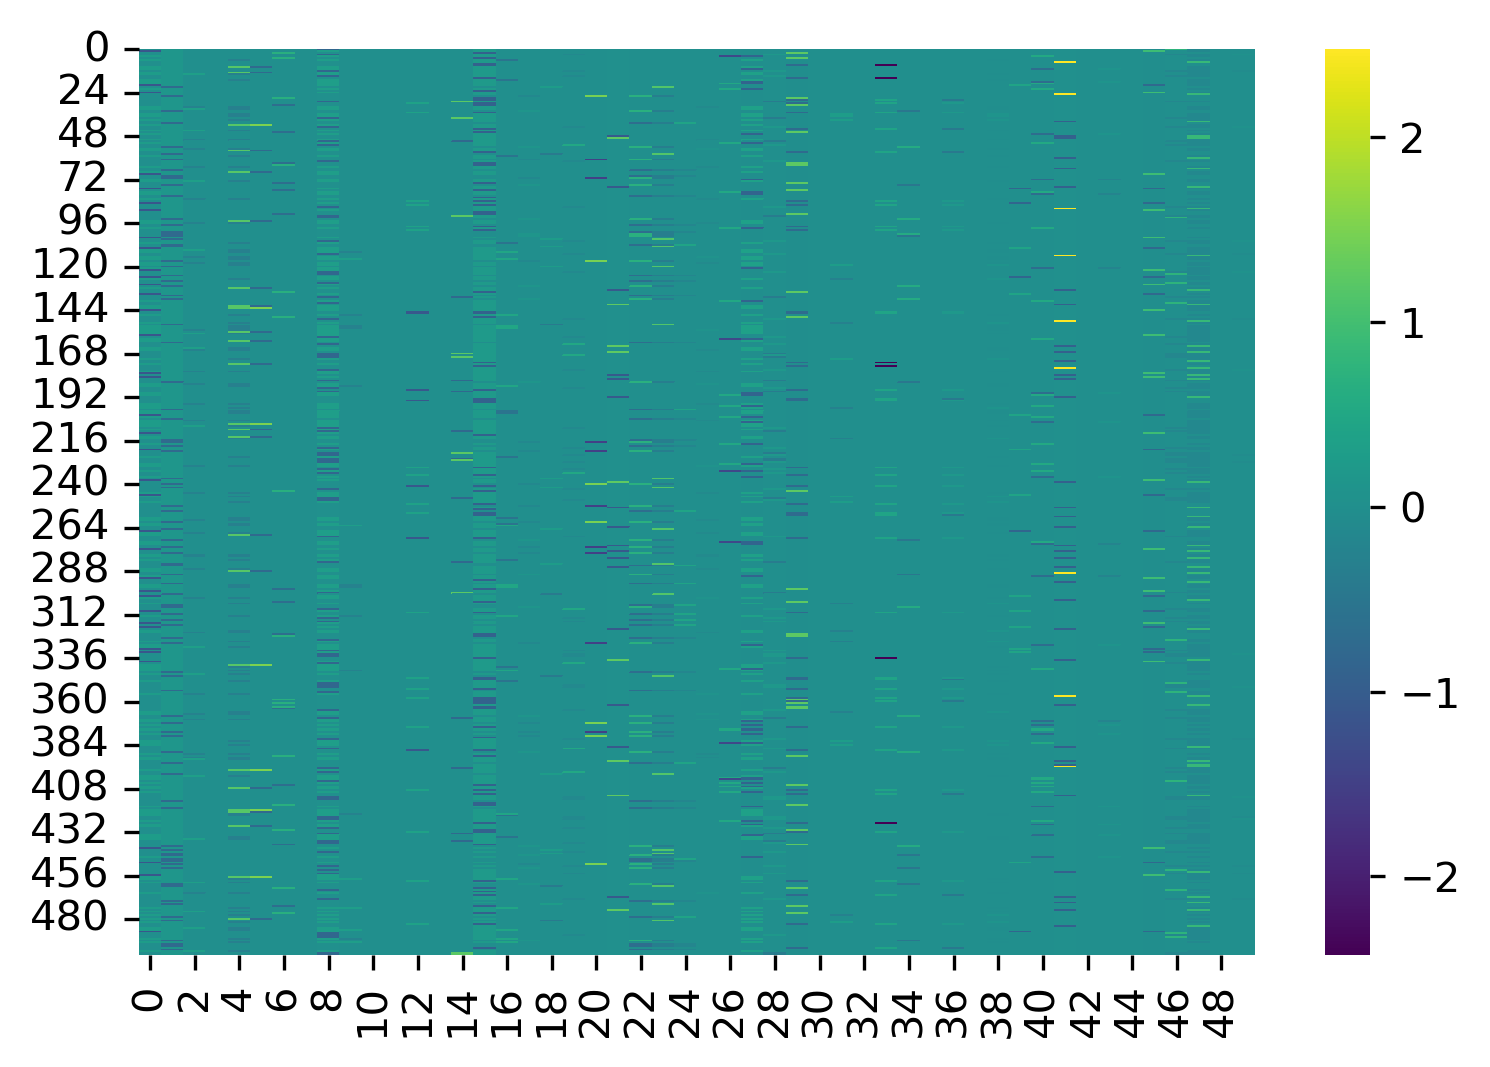

In [91]:
keep_idx = [i for i in range(len(linear_results[0]["lasso_raw"]["scorer_fits"][0].coef_))\
            if i not in linear_results[0]["lasso_raw"]["start_indices"][0][:-1]]
x = linear_results[0]["lasso_raw"]["X_transformed"][0][:, keep_idx]
coefs = linear_results[0]["lasso_raw"]["scorer_fits"][0].coef_[keep_idx]
sns.heatmap(x * coefs, cmap="viridis")

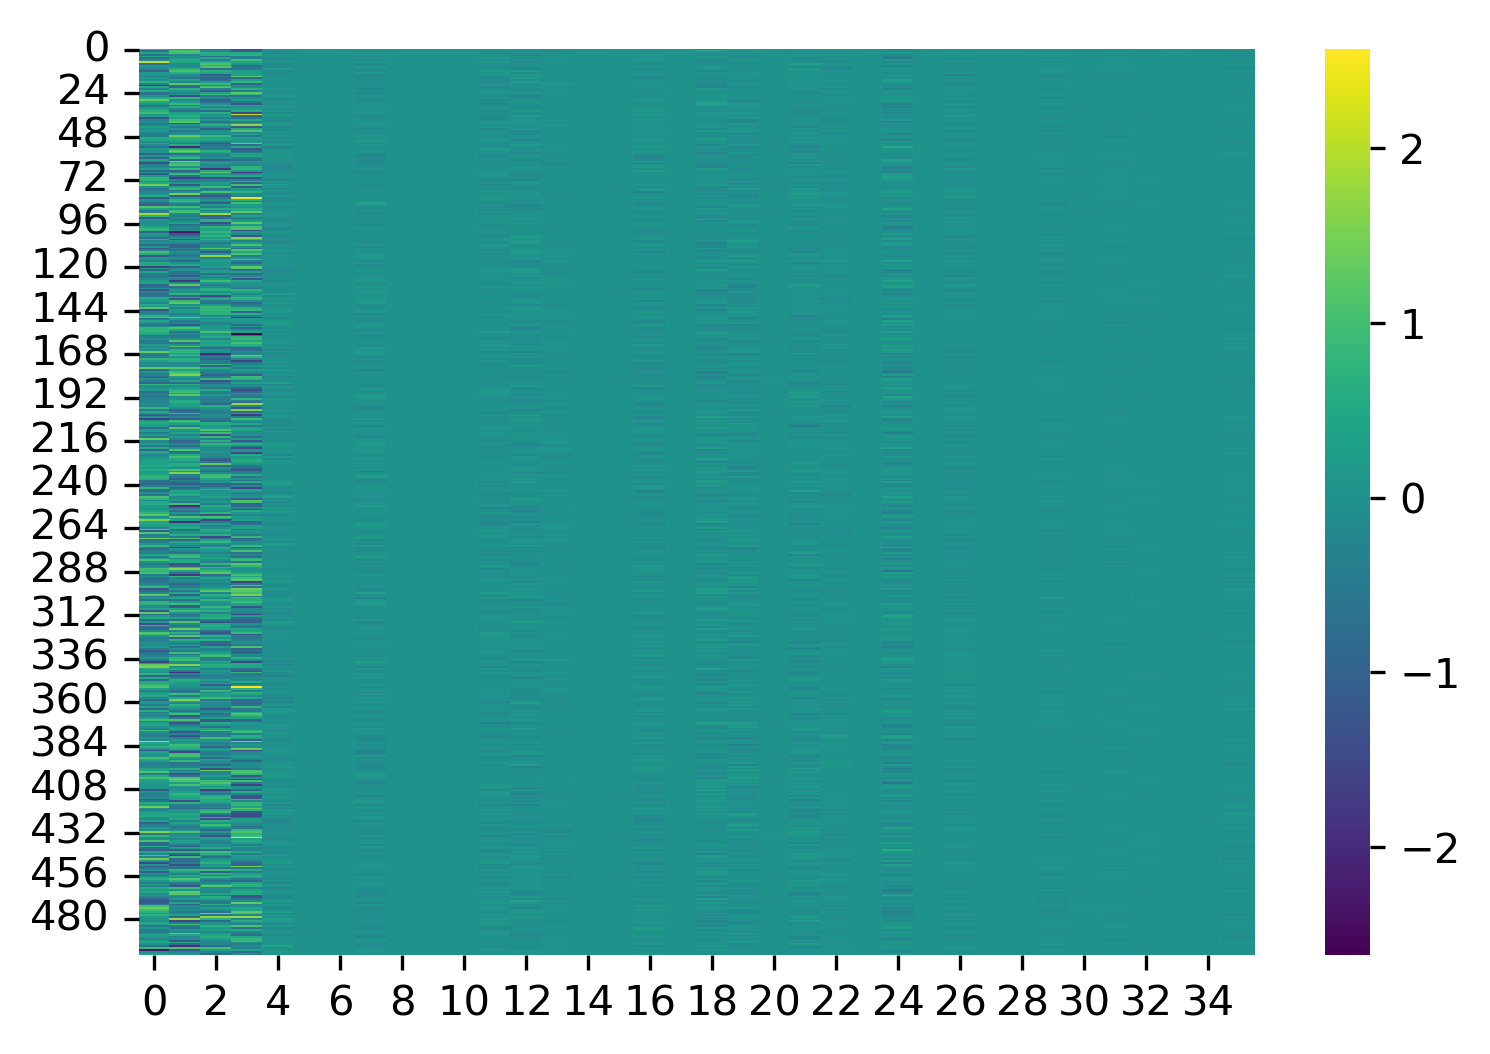

In [92]:
keep_idx = [i for i in range(len(linear_results[0]["lasso_raw"]["scorer_fits"][0].coef_))
            if i in linear_results[0]["lasso_raw"]["start_indices"][0][:-1]]
x = linear_results[0]["lasso_raw"]["X_transformed"][0][:, keep_idx]
coefs = linear_results[0]["lasso_raw"]["scorer_fits"][0].coef_[keep_idx]
sns.heatmap(x * coefs, cmap="viridis")

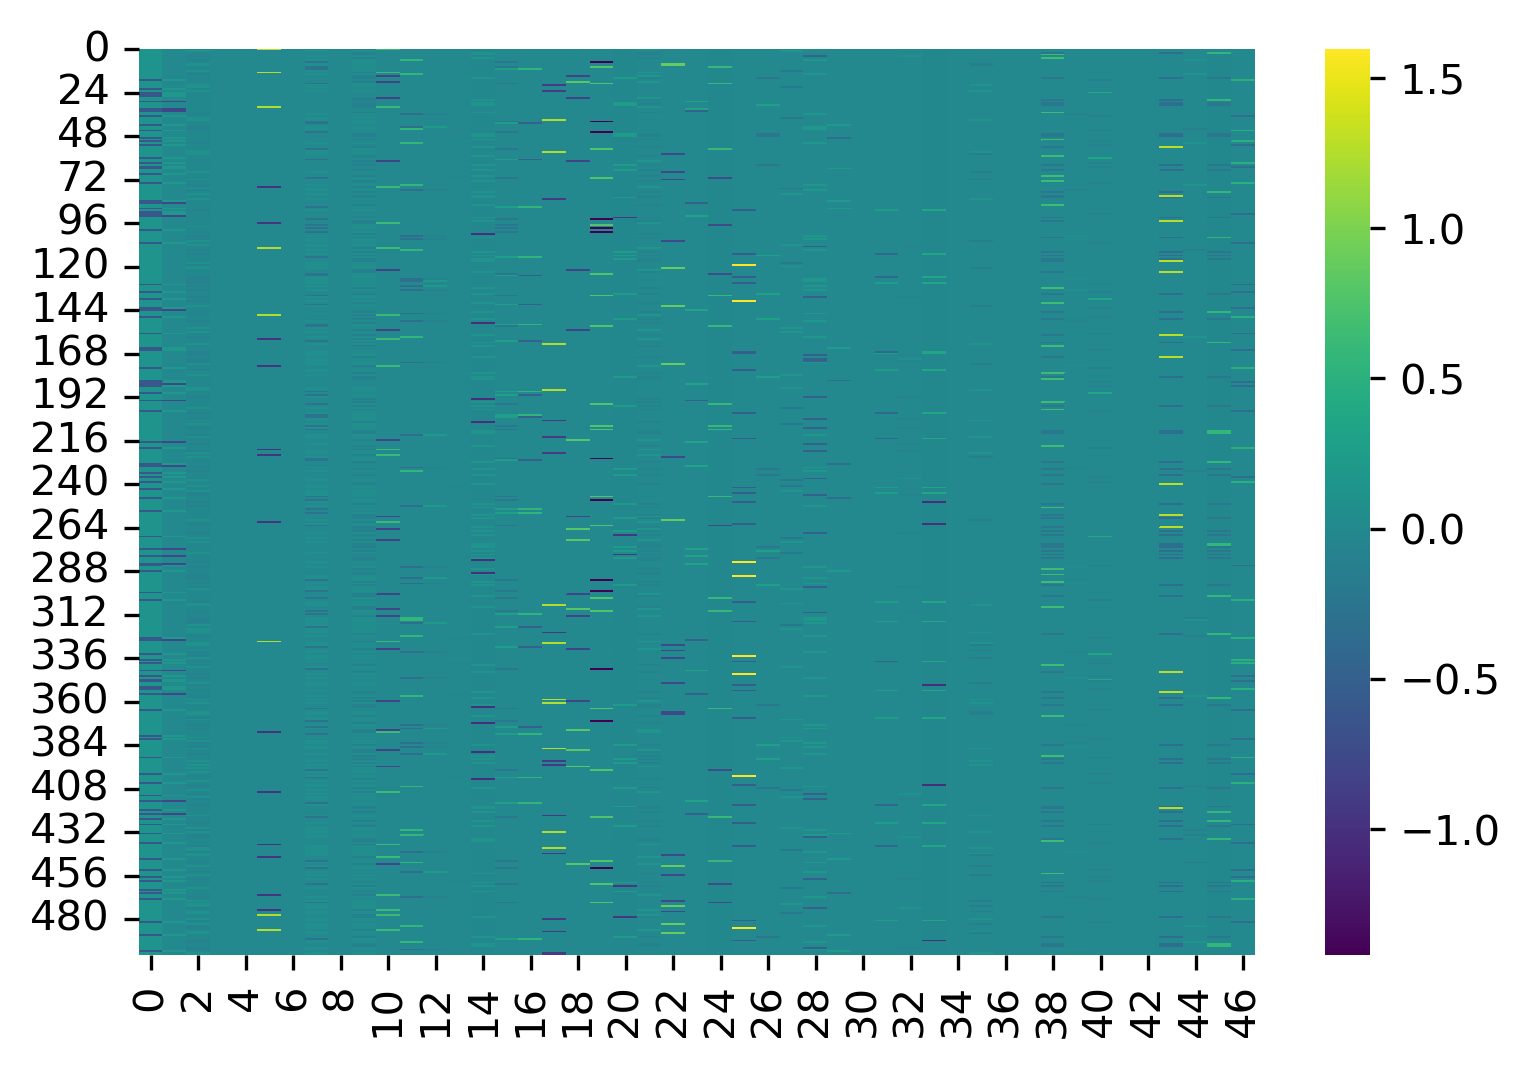

In [93]:
keep_idx = [i for i in range(len(lss_results[0]["lasso_raw"]["scorer_fits"][0].coef_))\
            if i not in lss_results[0]["lasso_raw"]["start_indices"][0][:-1]]
x = lss_results[0]["lasso_raw"]["X_transformed"][0][:, keep_idx]
coefs = lss_results[0]["lasso_raw"]["scorer_fits"][0].coef_[keep_idx]
sns.heatmap(x * coefs, cmap="viridis")

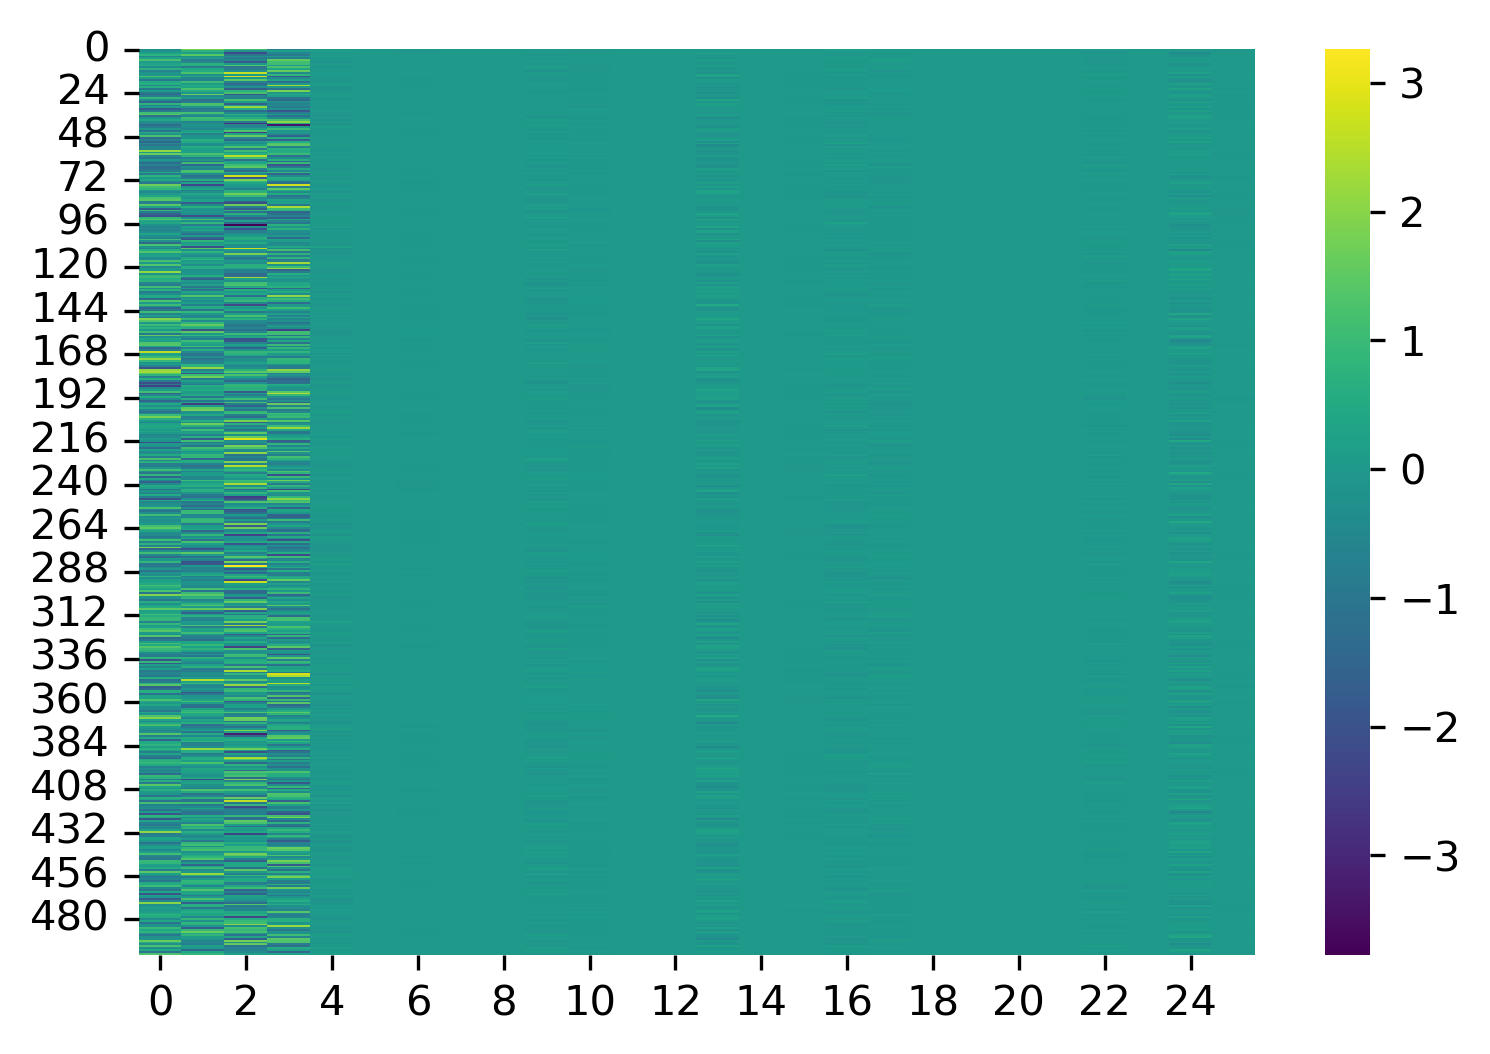

In [95]:
keep_idx = [i for i in range(len(lss_results[0]["lasso_raw"]["scorer_fits"][0].coef_))
            if i in lss_results[0]["lasso_raw"]["start_indices"][0][:-1]]
x = lss_results[0]["lasso_raw"]["X_transformed"][0][:, keep_idx]
coefs = lss_results[0]["lasso_raw"]["scorer_fits"][0].coef_[keep_idx]
sns.heatmap(x * coefs, cmap="viridis")

In [97]:
lss_results[0]["lasso_raw"]["start_indices"][0]

[0,
 0,
 2,
 6,
 12,
 16,
 18,
 18,
 21,
 21,
 24,
 24,
 26,
 29,
 29,
 29,
 31,
 34,
 37,
 37,
 37,
 39,
 39,
 39,
 42,
 42,
 44,
 44,
 48,
 48,
 51,
 51,
 54,
 57,
 59,
 61,
 61,
 63,
 63,
 63,
 63,
 63,
 63,
 65,
 65,
 69,
 71,
 71,
 71,
 71,
 73]